In [1]:
import yaml
import glob

import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader
import pytorch_lightning
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from models.ghostnet import GhostNet
from models.convolutional import CNN1D
import utils.dataset
from utils.dataset import ESC50, UrbanSound8K, AudioSet

from pytorch_grad_cam import GradCAMPlusPlus, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import librosa
import torchaudio

from matplotlib.ticker import Formatter, ScalarFormatter
from matplotlib.ticker import SymmetricalLogLocator

In [2]:
def load_dataloader(path, config, fold):
    transforms = None
    if config['model']['type'] == 'ghostnet':
        transforms = [torchaudio.transforms.MelSpectrogram(sample_rate=config['target_sr'],
                                                                f_min=0,
                                                                n_fft=config['transforms']['mel_spectrogram']['n_fft'],
                                                                win_length=config['transforms']['mel_spectrogram']['n_fft'],
                                                                hop_length=config['transforms']['mel_spectrogram']['hop_length'],
                                                                center=config['transforms']['mel_spectrogram']['center'],
                                                                normalized=config['transforms']['mel_spectrogram']['normalized'],
                                                                mel_scale="slaney",
                                                                n_mels=config['transforms']['mel_spectrogram']['n_mels'],
                                                                power=config['transforms']['mel_spectrogram']['power']),
                            torchaudio.transforms.AmplitudeToDB(top_db=80.0)]

    elif transforms['type'] == "mfcc":
        transforms = [torchaudio.transforms.MFCC(sample_rate=config['target_sr'], n_mfcc=config['transforms']["mfcc"]["n_mfcc"],
                                                 dct_type=config['transforms']["mfcc"]["dct_type"],
                                                 norm=config['transforms']["mfcc"]["norm"],
                                                 melkwargs={"f_min": 0,
                                                            "n_fft": config['transforms']['mel_spectrogram']['n_fft'],
                                                            "win_length": config['transforms']['mel_spectrogram']['n_fft'],
                                                            "hop_length": config['transforms']['mel_spectrogram']['hop_length'],
                                                            "center": config['transforms']['mel_spectrogram']['center'],
                                                            "normalized": config['transforms']['mel_spectrogram']['normalized'],
                                                            "mel_scale": "slaney",
                                                            "n_mels": config['transforms']['mel_spectrogram']['n_mels'],
                                                            "power": config['transforms']['mel_spectrogram']['power']})]
    if config['datasets']['main'] == 'esc50':
        dataset = ESC50(train=False,
                annotations_file=config['datasets']['esc50']['annotations_file'],
                audio_dir=config['datasets']['esc50']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)
    elif config['datasets']['main'] == 'urbansound8k':
        dataset = UrbanSound8K(train=False,
                annotations_file=config['datasets']['urbansound8k']['annotations_file'],
                audio_dir=config['datasets']['urbansound8k']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)
    
    return DataLoader(dataset=dataset, drop_last=True, num_workers=config['workers'], collate_fn=utils.dataset.collate_fn, persistent_workers=True)

In [3]:
class LatentSpaceCNN1D(CNN1D):
    def __init__(self, learning_rate=1e-3, log_path='./', patience=20):
        super().__init__(learning_rate, log_path, patience)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.linear[:-1](x)
        return torch.flatten(x, 1)

class LatentSpaceGhostNet(GhostNet):
    def __init__(self, cfgs,  learning_rate, log_path, patience, num_classes=2, width=1.0, dropout=0.2):
        super().__init__(cfgs,  learning_rate, log_path, patience, num_classes, width, dropout)
    
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = self.conv_head(x)
        x = self.act2(x)
        x = x.reshape(-1, 512)
        if self.dropout > 0.:
            x = F.dropout(x, p=self.dropout, training=self.training)
        return torch.flatten(x, 1)

In [4]:
def load_model(path, config, fold):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'cnn1d':
        return LatentSpaceCNN1D.load_from_checkpoint(checkpoint_path=model_path,
                                                        learning_rate=config['learning_rate'],
                                                        log_path=path,
                                                        patience=int(config['epochs'] / 10))
    elif config['model']['type'] == 'ghostnet':
        return LatentSpaceGhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                                                cfgs=config['model']['ghostnet']['stages'],
                                                                width=config['model']['ghostnet']['width'],
                                                                learning_rate=config['learning_rate'],
                                                                log_path=path,
                                                                patience=int(config['epochs'] / 10))

In [5]:
def get_features(model, dataloader):
    model.eval()
    features = None
    labels = None

    for batch in tqdm(dataloader, desc='Running the model inference'):
        signal = batch[0].to('cpu')
        label = np.vstack([batch[1]]*len(signal))

        with torch.no_grad():
            output = model(signal)
        current_features= output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features
        if labels is not None:
            labels = np.concatenate((labels, label))
        else:
            labels = label

    return features, labels.argmax(1)

In [6]:
def get_dataset_features(dataloader):
    features = None
    labels = None

    for batch in tqdm(dataloader, desc='Running the model inference'):
        current_features= batch[0].to('cpu').numpy()
        label = np.vstack([batch[1]]*len(batch[0]))
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features
        if labels is not None:
            labels = np.concatenate((labels, label))
        else:
            labels = label

    return features, labels.argmax(1)

In [7]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def plot_tsne(features, labels, perplexity, learning_rate):
    tsne = TSNE(n_components=3, random_state=2022, perplexity=perplexity, learning_rate=learning_rate, n_iter=2500).fit_transform(features)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tz = tsne[:, 2]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    tz = scale_to_01_range(tz)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    for label in [0, 1]:
        indices = [i for i, l in enumerate(labels) if l == label]
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        current_tz = np.take(tz, indices)
        ax.scatter(current_tx, current_ty, current_tz, label="Siren" if label else "Not Siren")
    # ax.set_title(title)
    ax.legend(loc='best')
    plt.show()

In [8]:
def plot_multiple_tsne(path, dataset_name, config, perplexity, learning_rate):
    all_features = None
    all_labels = None

    for f in config['datasets'][dataset_name]['folds']:
        print(f)
        pl_model_esc = load_model(path, config, f)
        dataloader_esc = load_dataloader(path, config, f)
        features, labels = get_features(pl_model_esc, dataloader_esc)
        print(features.shape, labels.shape)
    
        # if all_features is None:
        #     all_features = features
        #     all_labels = labels
        # else:
        #     all_features = np.concatenate((all_features, features))
        #     all_labels = np.concatenate((all_labels, labels))

        plot_tsne(features, labels, perplexity, learning_rate)

In [9]:
def plot_multiple_dataset_tsne(path, dataset_name, config, perplexity, learning_rate):
    all_features = None
    all_labels = None

    for f in config['datasets'][dataset_name]['folds']:
        print(f)
        dataloader_esc = load_dataloader(path, config, f)
        features, labels = get_dataset_features(dataloader_esc)
        features = features.reshape(features.shape[0], -1)   
        print(features.shape, labels.shape)
        # if all_features is None:
        #     all_features = features
        #     all_labels = labels
        # else:'
        #     all_features = np.concatenate((all_features, features))
        #     all_labels = np.concatenate((all_labels, labels))

        plot_tsne(features, labels, perplexity, learning_rate)

1


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 33.64it/s]


(1600, 1440) (1600,)


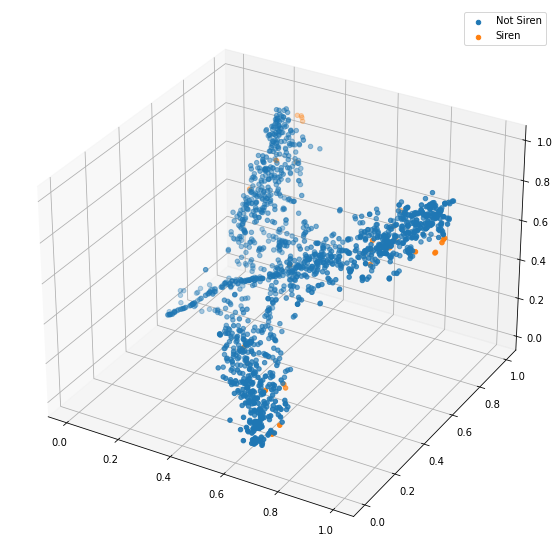

2


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 34.14it/s]


(1600, 1440) (1600,)


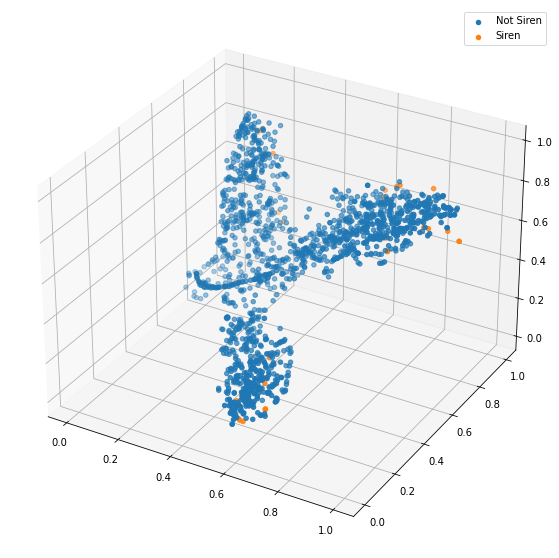

3


Running the model inference: 100%|██████████| 400/400 [00:12<00:00, 31.49it/s]


(1600, 1440) (1600,)


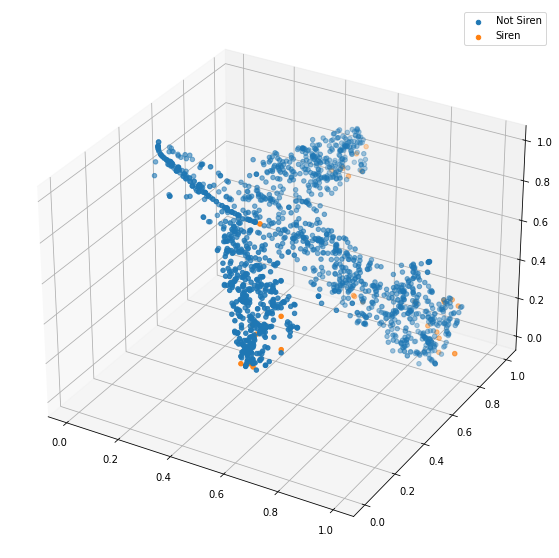

4


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 33.43it/s]


(1600, 1440) (1600,)


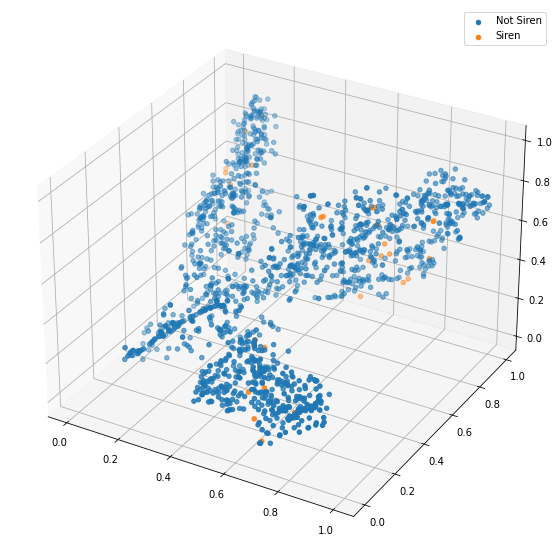

5


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 33.72it/s]


(1600, 1440) (1600,)


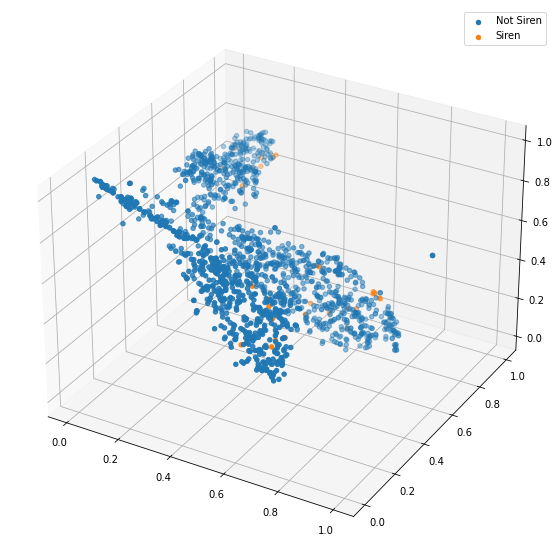

In [10]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_dataset_tsne(path, 'esc50', config, perplexity=50, learning_rate=50)

1


Running the model inference: 100%|██████████| 873/873 [00:21<00:00, 39.88it/s]


(2430, 1440) (2430,)


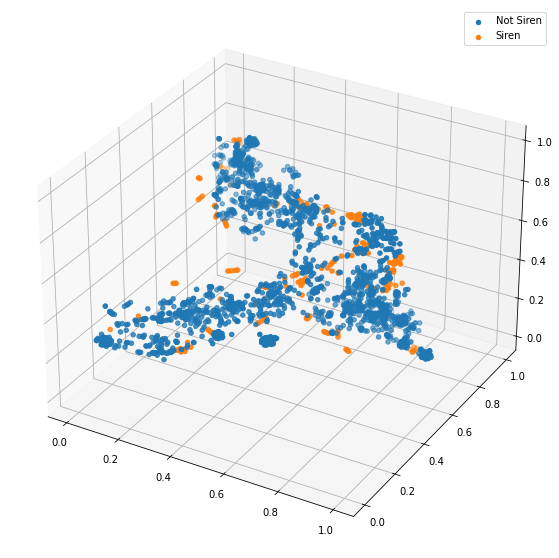

2


Running the model inference: 100%|██████████| 888/888 [00:28<00:00, 31.10it/s]


(2422, 1440) (2422,)


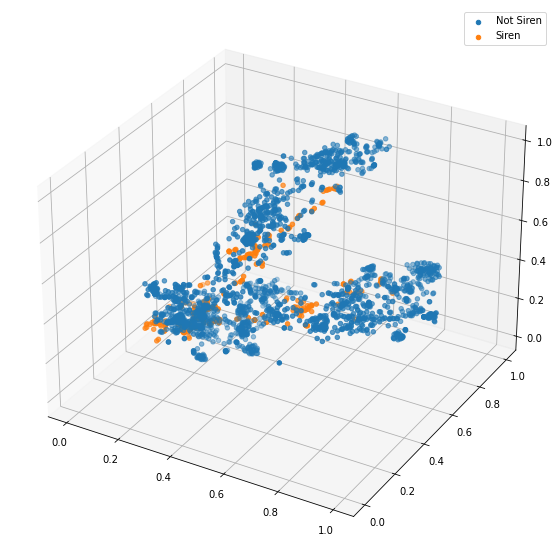

3


Running the model inference: 100%|██████████| 925/925 [00:28<00:00, 32.49it/s]


(2587, 1440) (2587,)


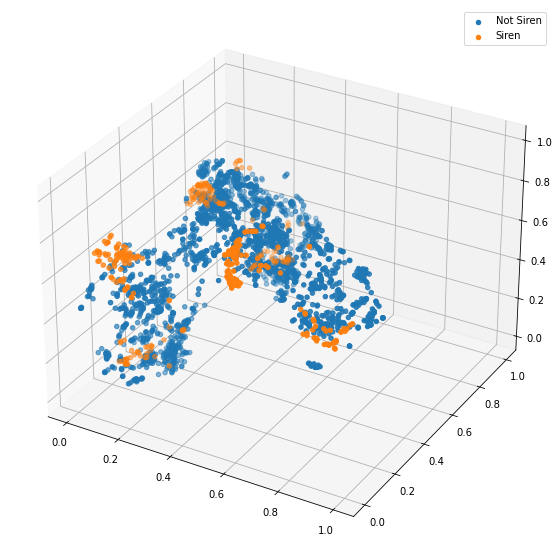

4


Running the model inference: 100%|██████████| 990/990 [00:23<00:00, 41.83it/s] 


(2707, 1440) (2707,)


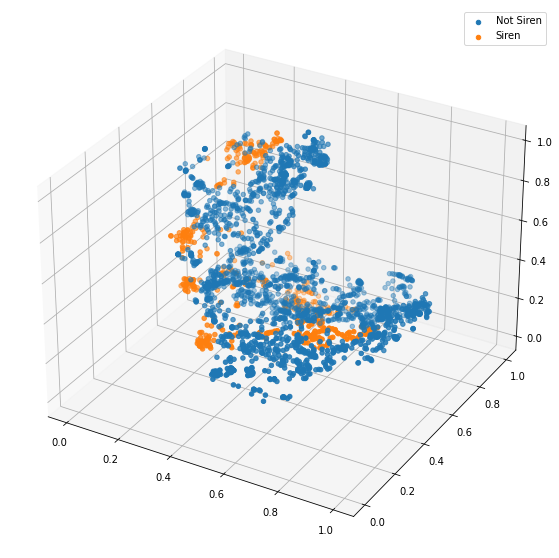

5


Running the model inference: 100%|██████████| 936/936 [00:25<00:00, 36.69it/s]


(2555, 1440) (2555,)


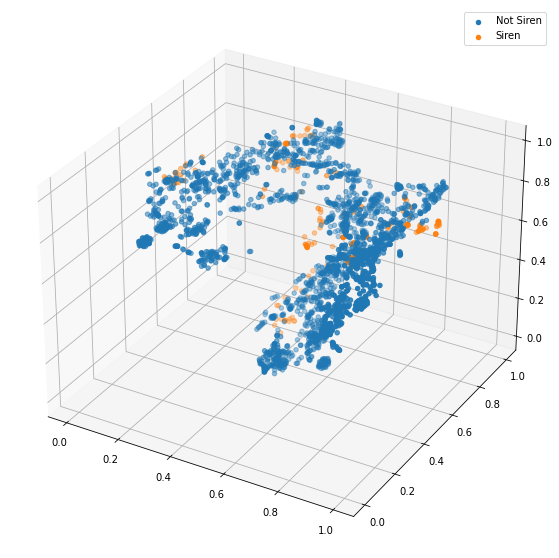

6


Running the model inference: 100%|██████████| 823/823 [00:25<00:00, 31.87it/s]


(2266, 1440) (2266,)


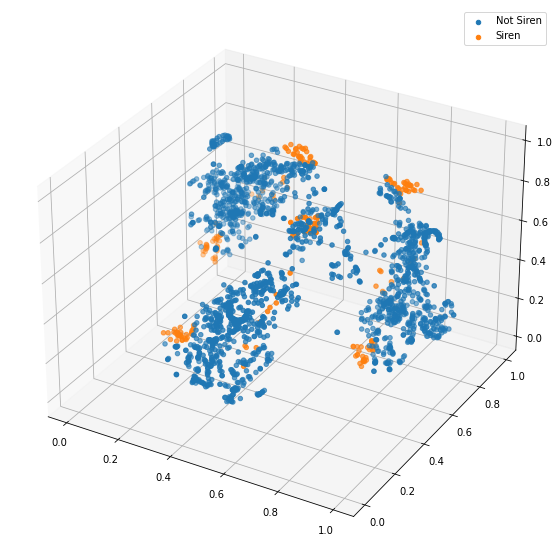

7


Running the model inference: 100%|██████████| 838/838 [00:24<00:00, 34.35it/s]


(2348, 1440) (2348,)


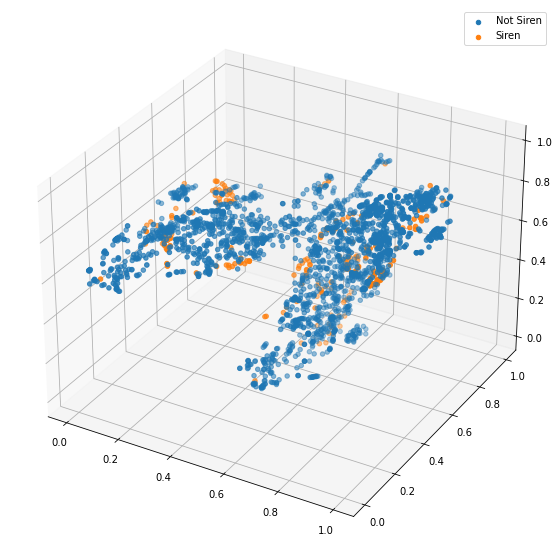

8


Running the model inference: 100%|██████████| 806/806 [00:25<00:00, 32.05it/s]


(2223, 1440) (2223,)


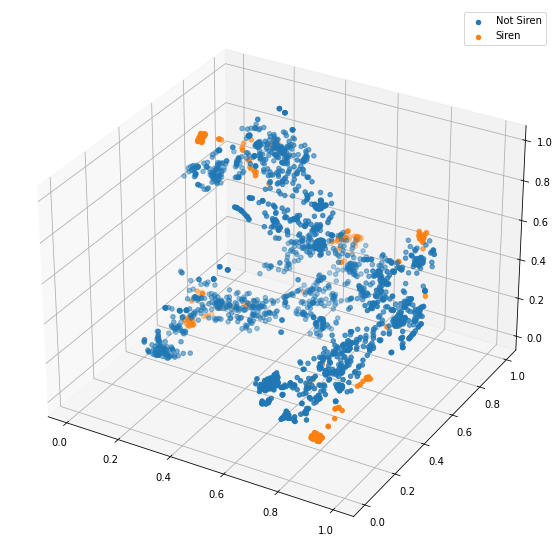

9


Running the model inference: 100%|██████████| 816/816 [00:22<00:00, 36.96it/s]


(2278, 1440) (2278,)


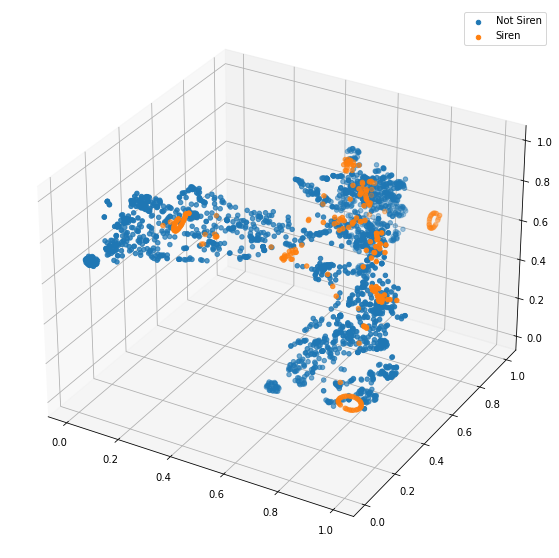

10


Running the model inference: 100%|██████████| 837/837 [00:24<00:00, 34.16it/s]


(2326, 1440) (2326,)


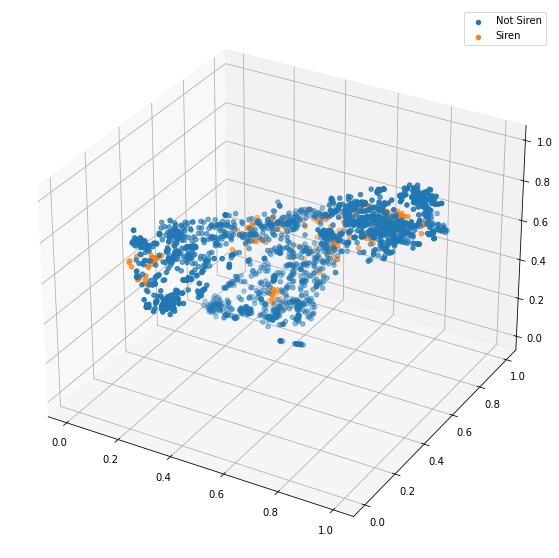

In [12]:
path = "./trained_models/us8k/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_dataset_tsne(path, 'urbansound8k', config, perplexity=50, learning_rate=50)

1


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 35.48it/s]


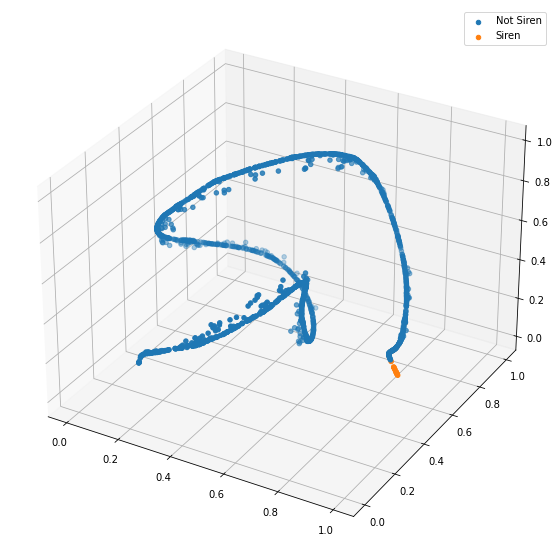

2


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 36.27it/s]


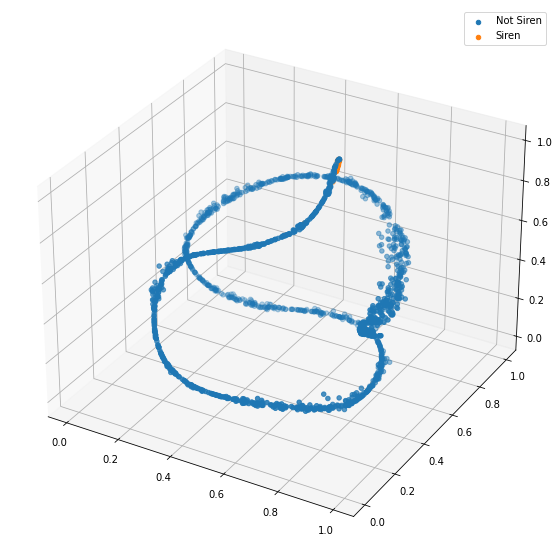

3


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 34.94it/s]


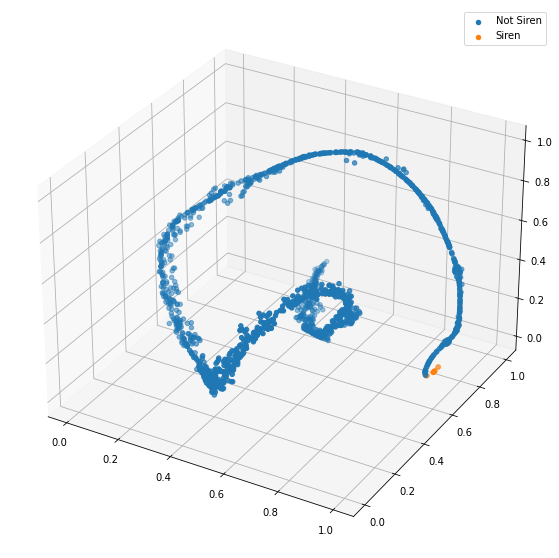

4


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 34.10it/s]


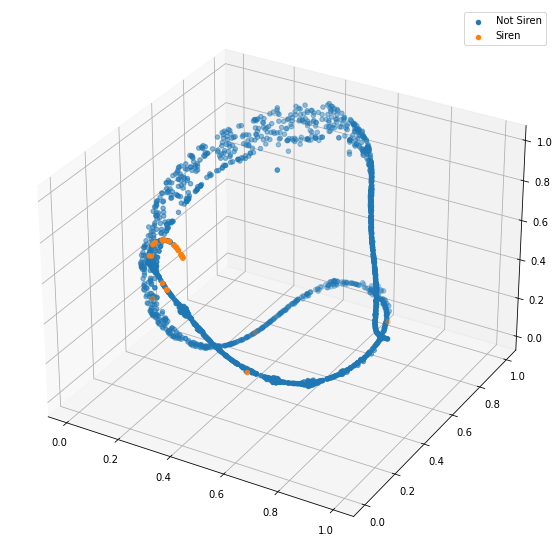

5


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 35.51it/s]


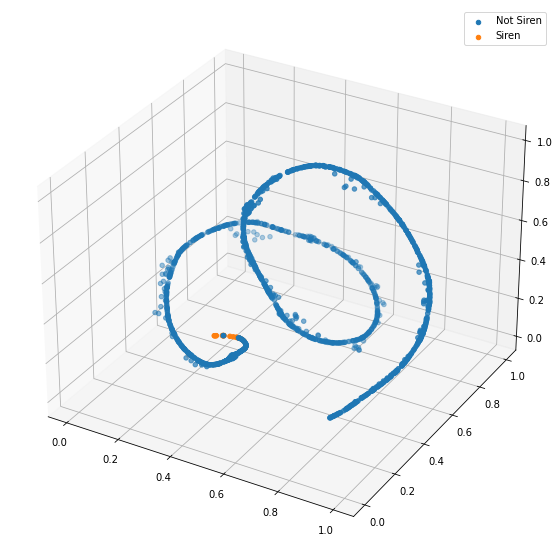

In [ ]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config, perplexity=50, learning_rate=50)

1


Running the model inference: 100%|██████████| 873/873 [00:20<00:00, 42.25it/s]


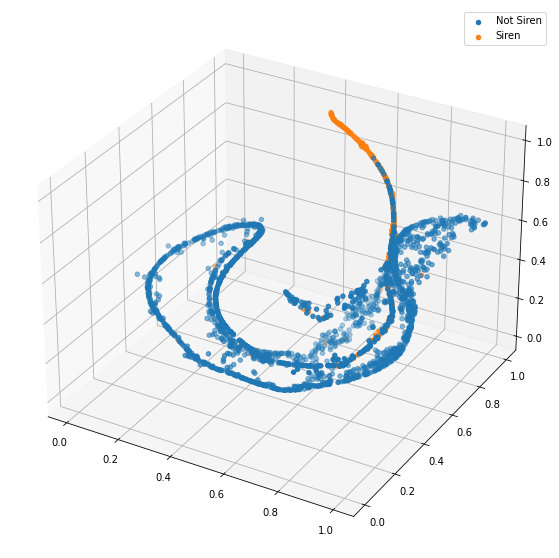

2


Running the model inference: 100%|██████████| 888/888 [00:21<00:00, 41.08it/s]


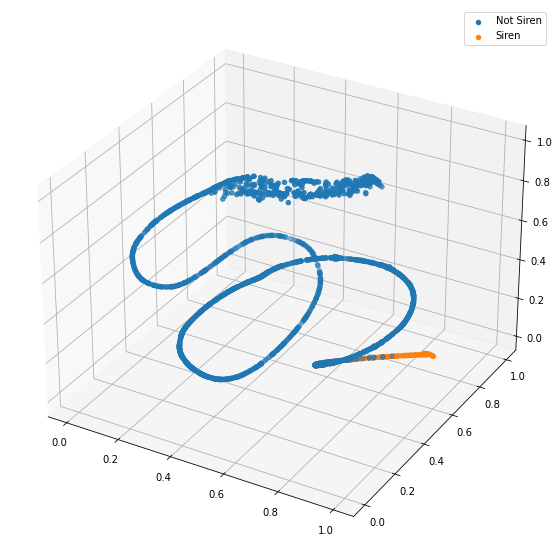

3


Running the model inference: 100%|██████████| 925/925 [00:23<00:00, 39.19it/s]


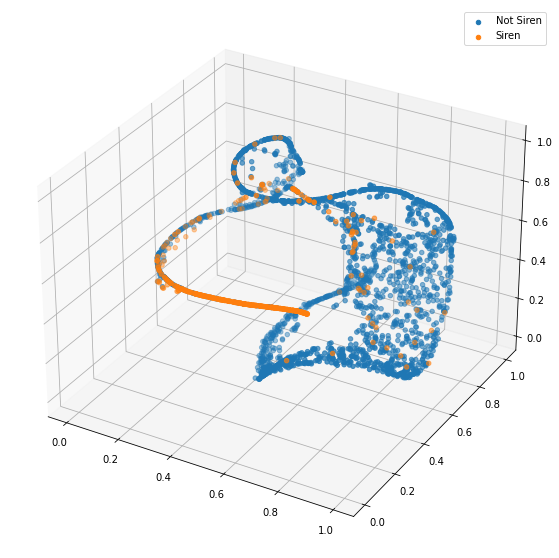

4


Running the model inference: 100%|██████████| 990/990 [00:22<00:00, 44.73it/s]


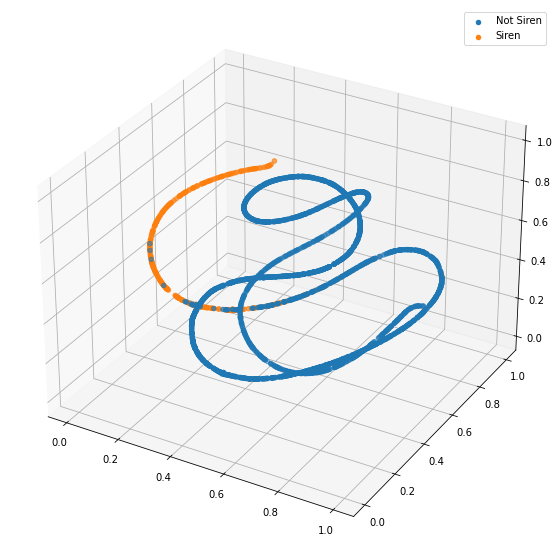

5


Running the model inference: 100%|██████████| 936/936 [00:22<00:00, 41.26it/s]


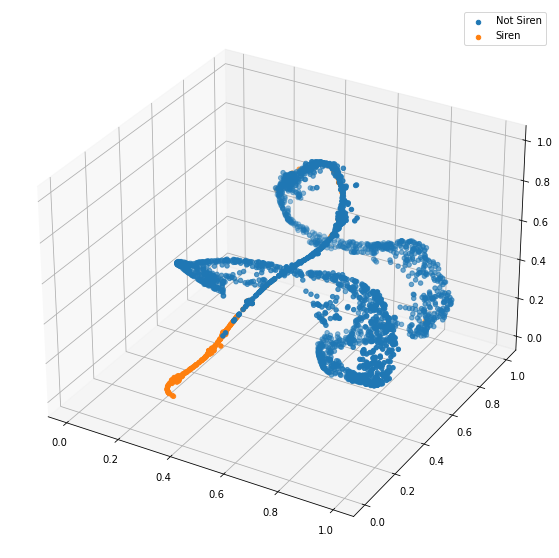

6


Running the model inference: 100%|██████████| 823/823 [00:23<00:00, 35.59it/s]


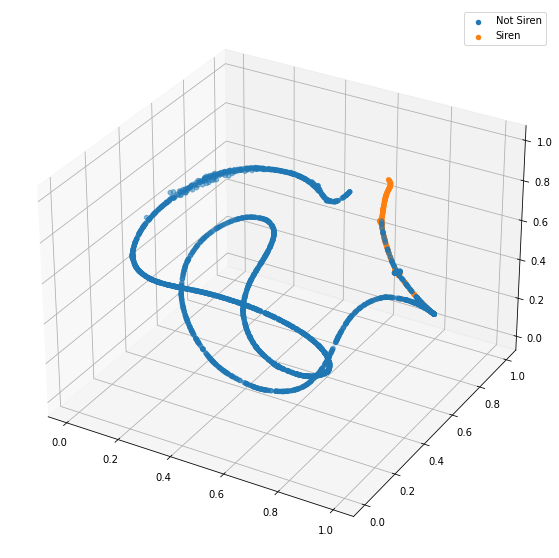

7


Running the model inference: 100%|██████████| 838/838 [00:20<00:00, 39.98it/s]


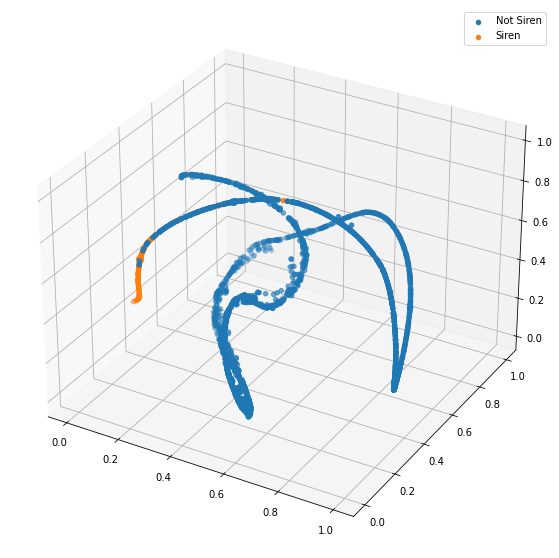

8


Running the model inference: 100%|██████████| 806/806 [00:20<00:00, 39.12it/s]


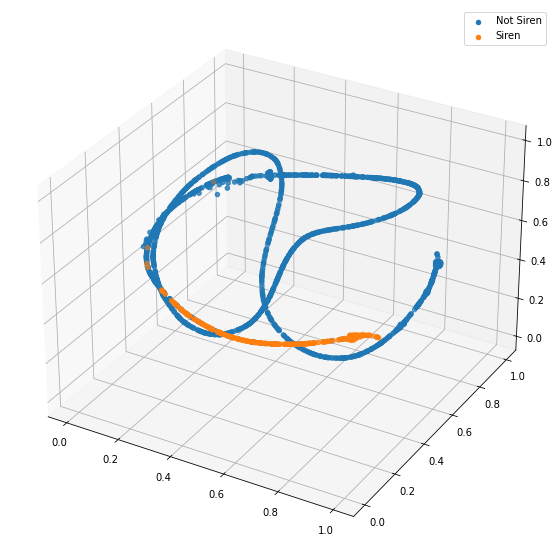

9


Running the model inference: 100%|██████████| 816/816 [00:19<00:00, 42.44it/s]


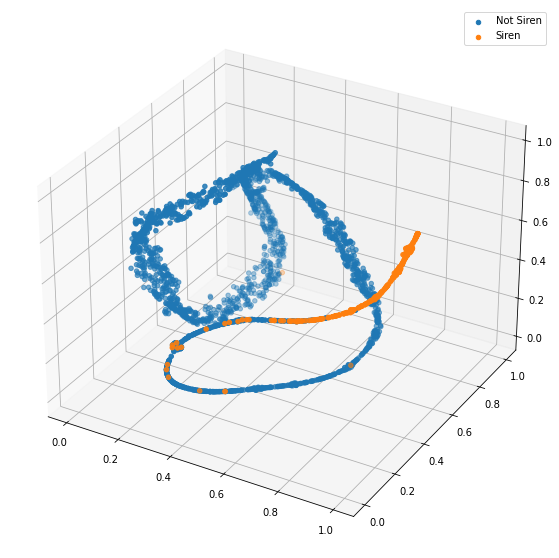

10


Running the model inference: 100%|██████████| 837/837 [00:20<00:00, 40.50it/s]


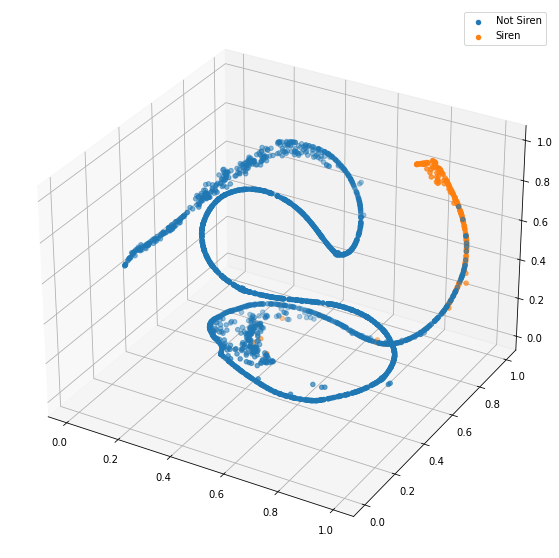

In [ ]:
path = "./trained_models/us8k/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'urbansound8k', config, perplexity=50, learning_rate=50)


1


Running the model inference: 100%|██████████| 400/400 [00:10<00:00, 38.49it/s]


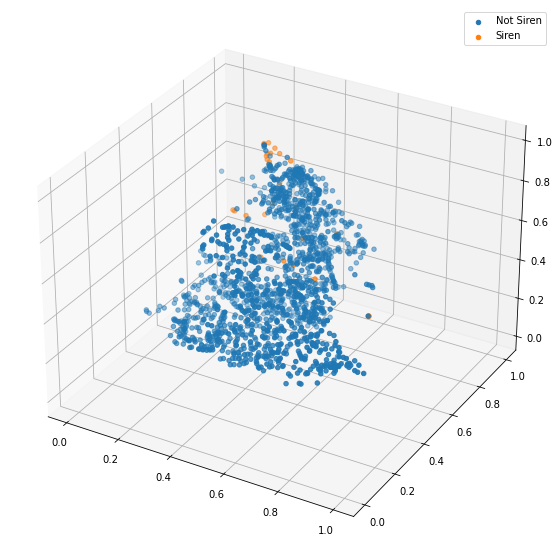

2


Running the model inference: 100%|██████████| 400/400 [00:10<00:00, 37.62it/s]


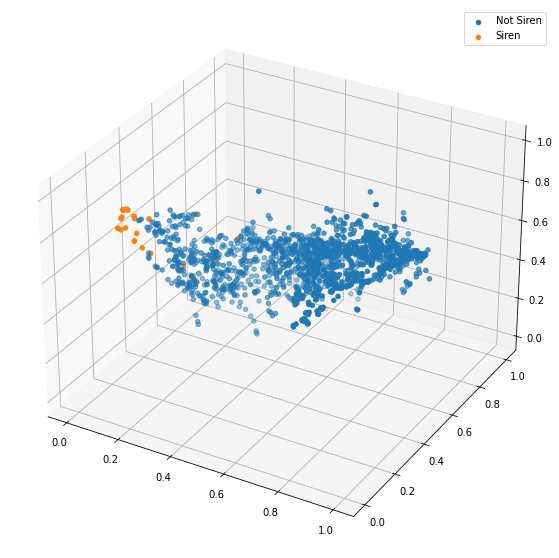

3


Running the model inference: 100%|██████████| 400/400 [00:10<00:00, 38.10it/s]


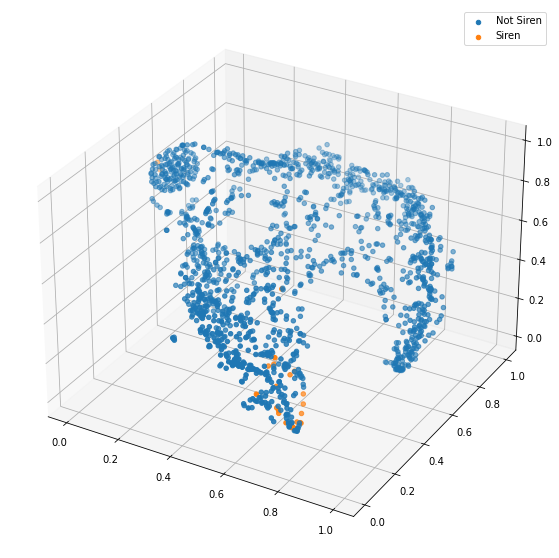

4


Running the model inference: 100%|██████████| 400/400 [00:10<00:00, 37.99it/s]


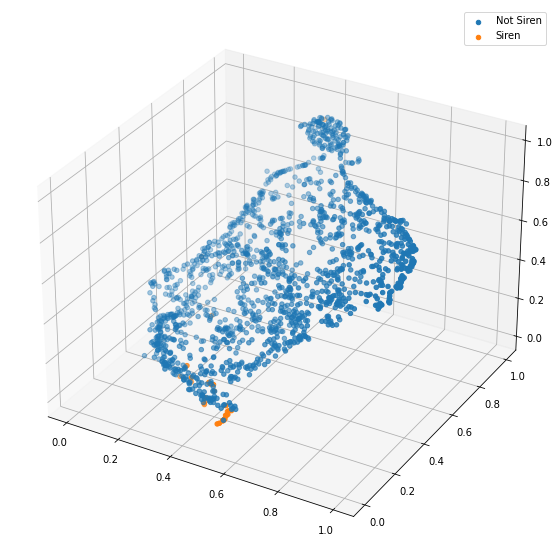

5


Running the model inference: 100%|██████████| 400/400 [00:10<00:00, 37.98it/s]


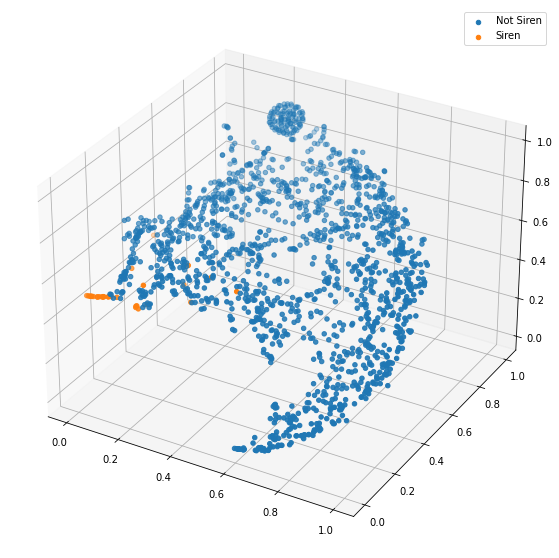

In [ ]:
path = "./trained_models/esc50/16000-15-conv1d"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config,  perplexity=50, learning_rate=50)

1


Running the model inference: 100%|██████████| 873/873 [00:15<00:00, 56.57it/s] 


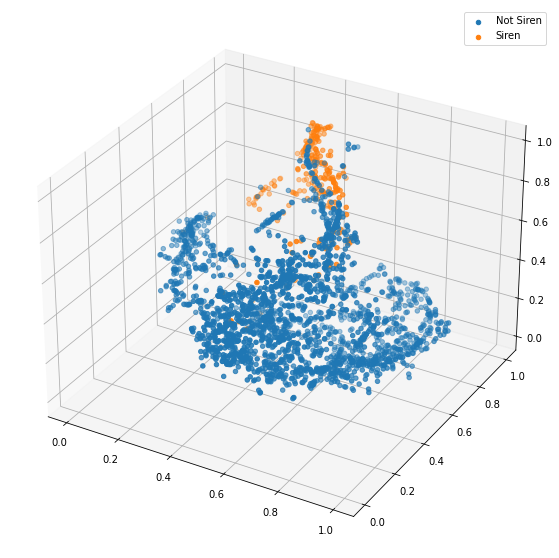

2


Running the model inference: 100%|██████████| 888/888 [00:17<00:00, 50.51it/s]


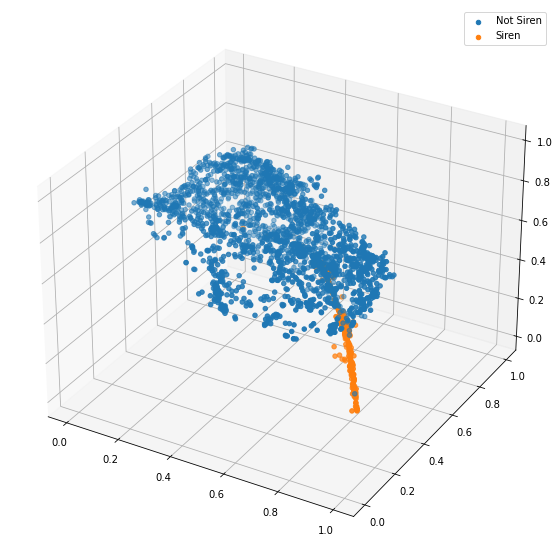

3


Running the model inference: 100%|██████████| 925/925 [00:20<00:00, 45.78it/s] 


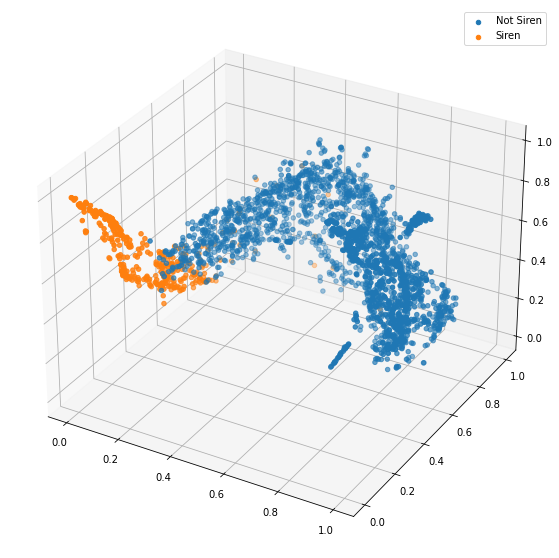

4


Running the model inference: 100%|██████████| 990/990 [00:16<00:00, 60.51it/s] 


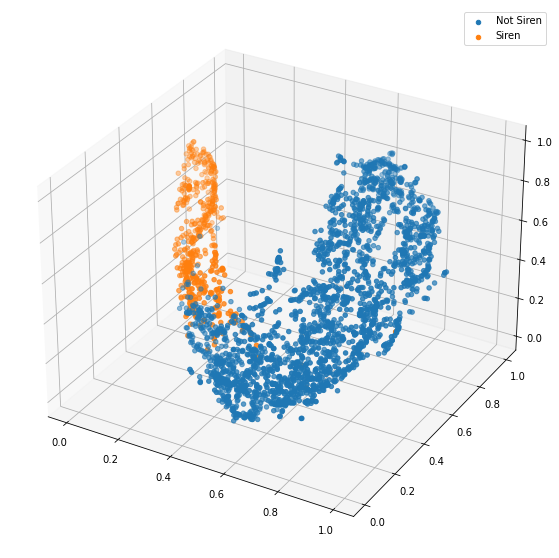

5


Running the model inference: 100%|██████████| 936/936 [00:18<00:00, 52.00it/s] 


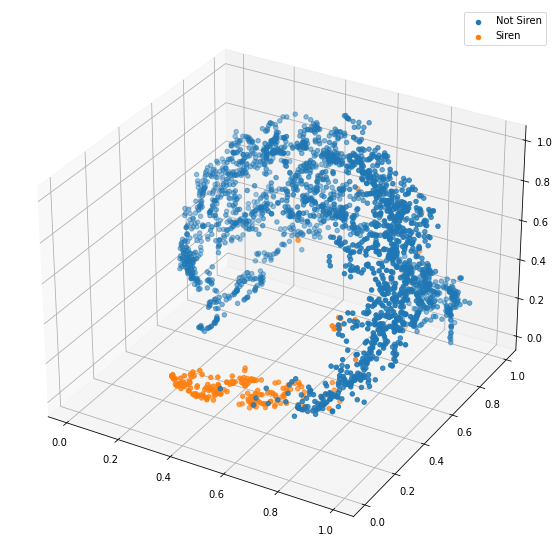

6


Running the model inference: 100%|██████████| 823/823 [00:18<00:00, 44.38it/s]


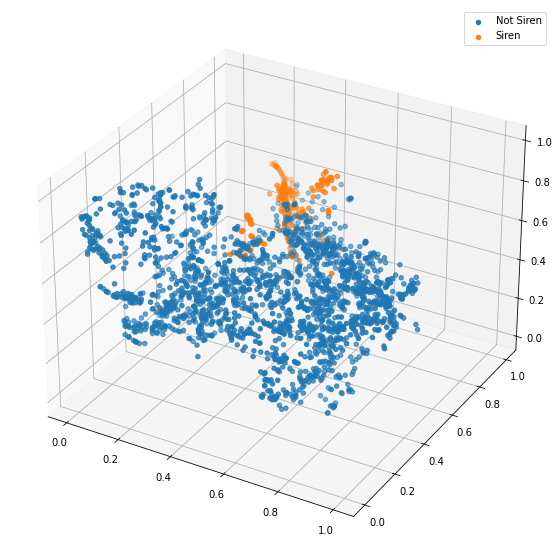

7


Running the model inference: 100%|██████████| 838/838 [00:17<00:00, 47.61it/s] 


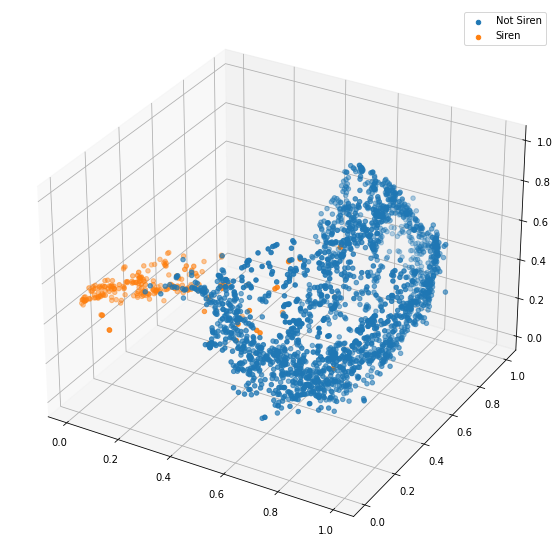

8


Running the model inference: 100%|██████████| 806/806 [00:17<00:00, 45.27it/s]


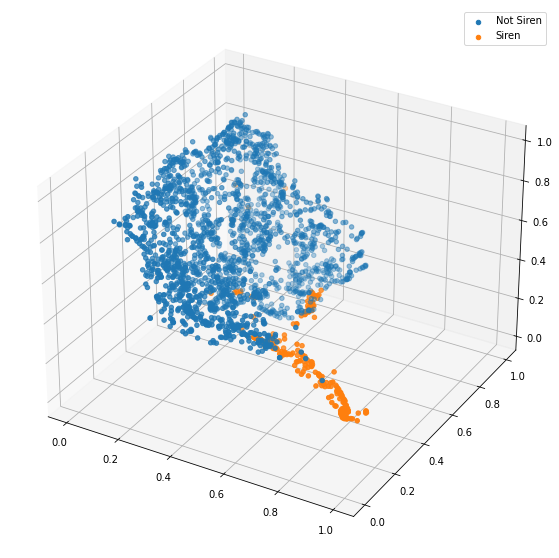

9


Running the model inference: 100%|██████████| 816/816 [00:15<00:00, 51.37it/s] 


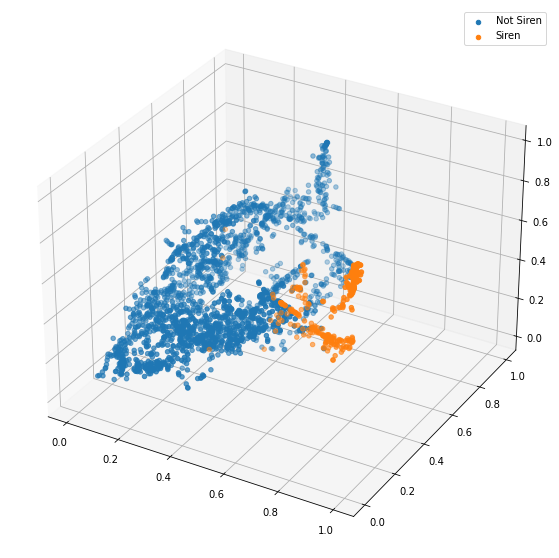

10


Running the model inference: 100%|██████████| 837/837 [00:18<00:00, 46.01it/s]


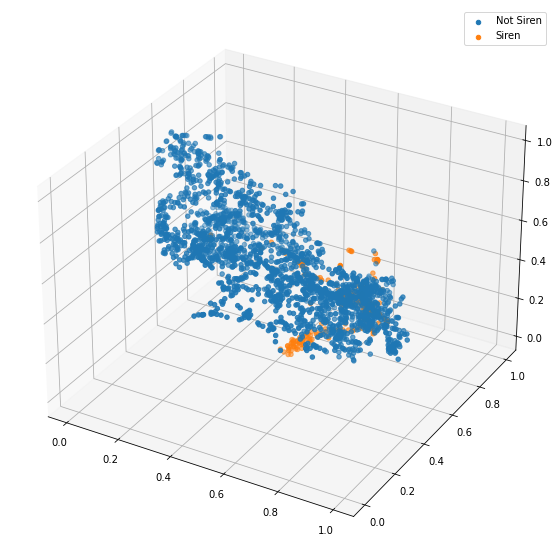

In [ ]:
path = "./trained_models/us8k/16000-15-conv1d"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'urbansound8k', config, perplexity=50, learning_rate=50)

# Grad-CAM

In [10]:
def load_cam_model(path, config, fold, layers_from_end):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'ghostnet':
        model = GhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                              cfgs=config['model']['ghostnet']['stages'],
                                              width=config['model']['ghostnet']['width'],
                                              learning_rate=config['learning_rate'],
                                              log_path=path,
                                              patience=int(config['epochs'] / 10))
        return GradCAMPlusPlus(model=model, target_layers=[model.blocks[layers_from_end]]), model 

In [11]:
def plot_heatmap(heatmap, pred, mel_to_freq, n_mels, sr):
    plt.figure(figsize=(20, 10))
    ax = plt.axes()
    plt.imshow(heatmap, origin='lower')
    frames = range(heatmap.shape[1])
    t = np.round_(librosa.frames_to_time(frames, sr=sr, hop_length=512),2)

    ax.set_xticks([*range(0, heatmap.shape[1], 5)])
    ax.set_xticklabels(t[::5])
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    if pred is not None:
        font = {
            'size': 14,
            }        
        for i, p in enumerate(pred):
            plt.text((i) * heatmap.shape[1]//4 + 20, 34, 'Siren' if p else 'Not Siren', fontdict=font)
        
    if mel_to_freq:
        ax.set_yticks([*range(0, heatmap.shape[0], 3)])
        ax.set_yticklabels(librosa.mel_frequencies(n_mels, fmax=sr/2)[::3].astype(int))
        # ax.set_yscale("log") 
    plt.ylim((0,n_mels-1))


In [12]:
def plot_signal_and_heatmap(signal, label, cam_model, model, n_mels, sr):
    label = torch.argmax(label).item()
    print(f'Label: {label}')
    pred = []
    res = None
    for i in range(signal.shape[0]):
        signal_ = signal[i].unsqueeze(0)
        p = model(signal_)[1].item()
        grayscale_cam = cam_model(input_tensor=signal_, targets=[ClassifierOutputTarget(p)])
        grayscale_cam = grayscale_cam[0, :]
        pred.append(p)
        print(pred)
        signal_gray = ((signal_ - signal_.min())/(signal_.max()- signal_.min())).reshape(signal_.shape[2],signal_.shape[3])
        signal_rgb = cv2.cvtColor(signal_gray.numpy(), cv2.COLOR_GRAY2RGB)
        visualization = show_cam_on_image(signal_rgb, grayscale_cam, use_rgb=True)
        if res is None:
            res = visualization
        else:
            res = np.hstack([res, visualization])
    
    plot_heatmap(res, pred, mel_to_freq=True, n_mels=n_mels, sr=sr)


### ESC50

#### Siren 

In [64]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model, model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/ESC-50-master/audio/1-31482-A-42.wav
Label: 1
[0]
[0, 0]
[0, 0, 1]
[0, 0, 1, 1]


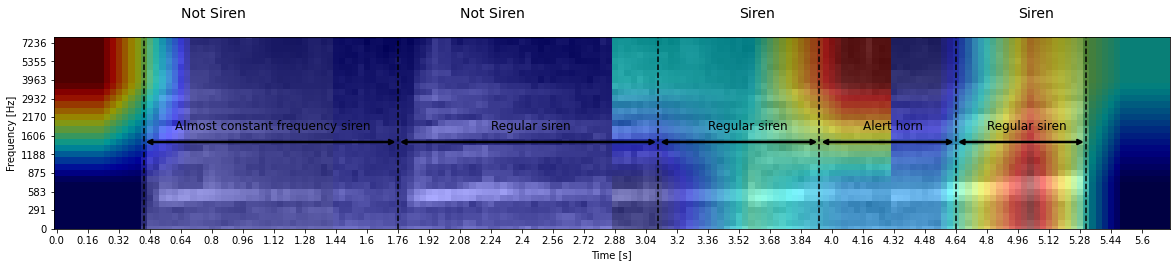

In [65]:
font_region = {
        'size': 12,
        'color': 'black'
}

signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, model, 32, 16000)

plt.text(19, 16, 'Almost constant frequency siren', fontdict=font_region)
plt.annotate('', xy=(14, 14), xytext=(55, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=[14,55], ymin=0, ymax=32, color='black', ls='--')

plt.text(70, 16, 'Regular siren', fontdict=font_region)
plt.annotate('', xy=(55, 14), xytext=(97, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=97, ymin=0, ymax=32, color='black', ls='--')

plt.text(105, 16, 'Regular siren', fontdict=font_region)
plt.annotate('', xy=(97, 14), xytext=(123, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=123, ymin=0, ymax=32, color='black', ls='--')

plt.text(130, 16, 'Alert horn', fontdict=font_region)
plt.annotate('', xy=(123, 14), xytext=(145, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=145, ymin=0, ymax=32, color='black', ls='--')

plt.text(150, 16, 'Regular siren', fontdict=font_region)
plt.annotate('', xy=(145, 14), xytext=(166, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=166, ymin=0, ymax=32, color='black', ls='--')

# ./data/ESC-50-master/audio/1-76831-E-42.wav

#### Car Horn

In [66]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 3
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model, model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/ESC-50-master/audio/3-51376-A-42.wav
Label: 1
[0]
[0, 1]
[0, 1, 1]
[0, 1, 1, 1]


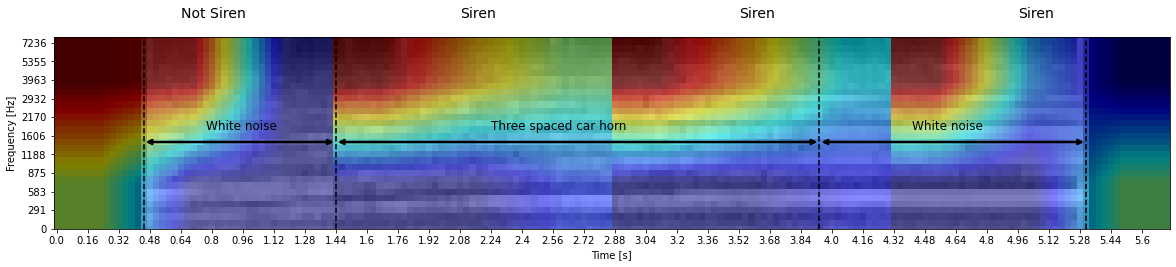

In [67]:
font_region = {
        'size': 12,
        'color': 'black'
}

signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, model, 32, 16000)

plt.text(24, 16, 'White noise', fontdict=font_region)
plt.annotate('', xy=(14, 14), xytext=(45, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=[14,45], ymin=0, ymax=32, color='black', ls='--')

plt.text(70, 16, 'Three spaced car horn', fontdict=font_region)
plt.annotate('', xy=(45, 14), xytext=(123, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=123, ymin=0, ymax=32, color='black', ls='--')

plt.text(138, 16, 'White noise', fontdict=font_region)
plt.annotate('', xy=(123, 14), xytext=(166, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=166, ymin=0, ymax=32, color='black', ls='--')


#./data/ESC-50-master/audio/3-161010-A-43.wav
            

#### Engine

In [237]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 5
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model, model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/ESC-50-master/audio/5-243773-A-44.wav
Label: 0
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0, 0]


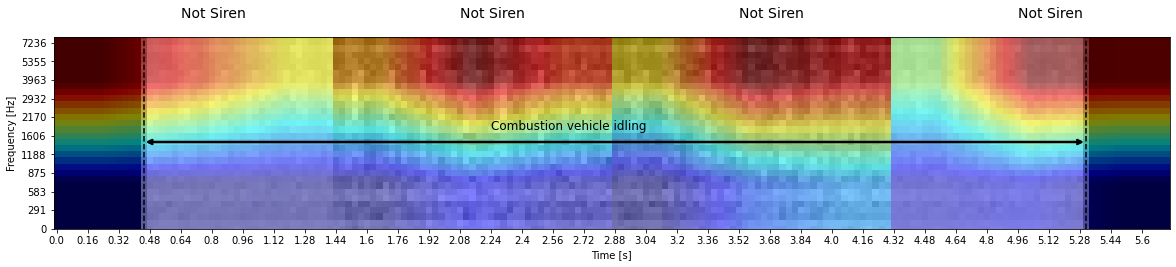

In [243]:
font_region = {
        'size': 12,
        'color': 'black'
}

signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, model, 32, 16000)

plt.text(70, 16, 'Combustion vehicle idling', fontdict=font_region)
plt.annotate('', xy=(14, 14), xytext=(166, 14),
            arrowprops=dict(arrowstyle='<->', color='black',lw=2.5))
plt.vlines(x=[14,166], ymin=0, ymax=32, color='black', ls='--')

# ./data/ESC-50-master/audio/5-243773-A-44.wav


#### UrbanSound 8K

#### Siren

In [ ]:
path = "./trained_models/us8k/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model, model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/UrbanSound8K/audio/fold1\118279-8-0-3.wav
Label: 1
[0]
[0, 1]
[0, 1, 0]


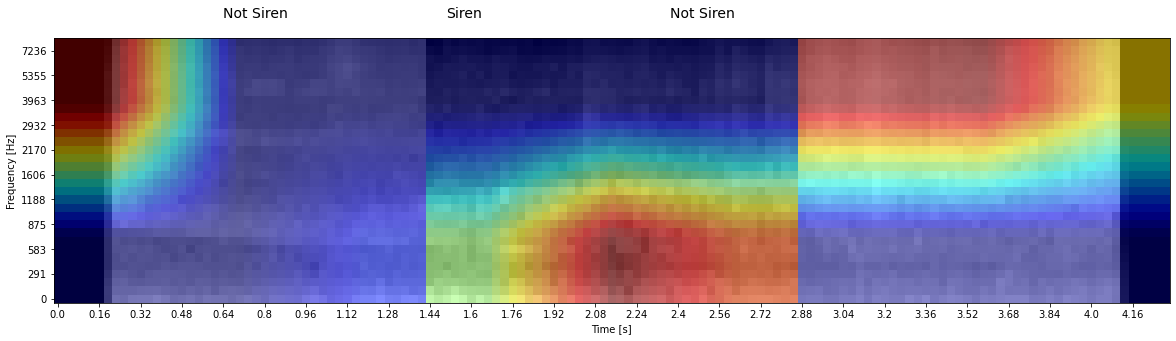

In [ ]:
signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, model, 32, 16000)

#### Car horn

In [ ]:
path = "./trained_models/us8k/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/UrbanSound8K/audio/fold1\19026-1-0-0.wav
Label: 0
(32, 45, 3)


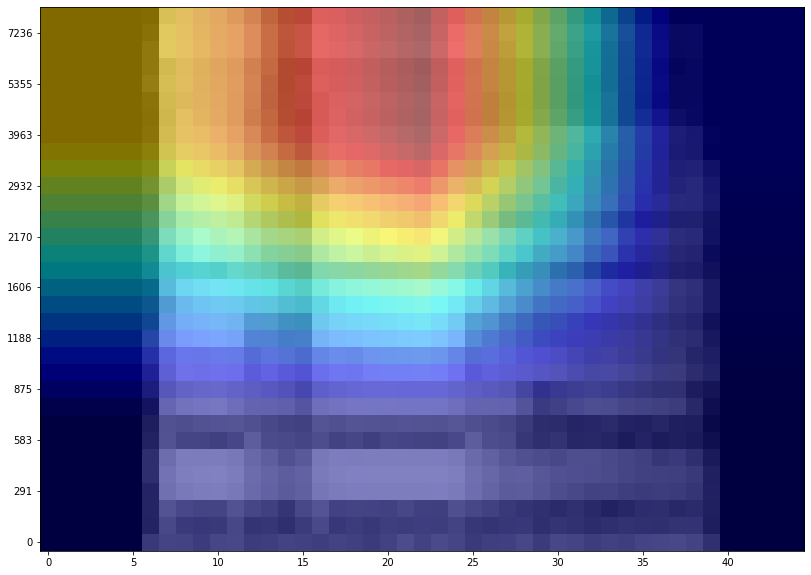

In [ ]:
signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

#### Engine

In [ ]:
path = "./trained_models/us8k/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

./data/UrbanSound8K/audio/fold1\101415-3-0-2.wav
Label: 0
(32, 135, 3)


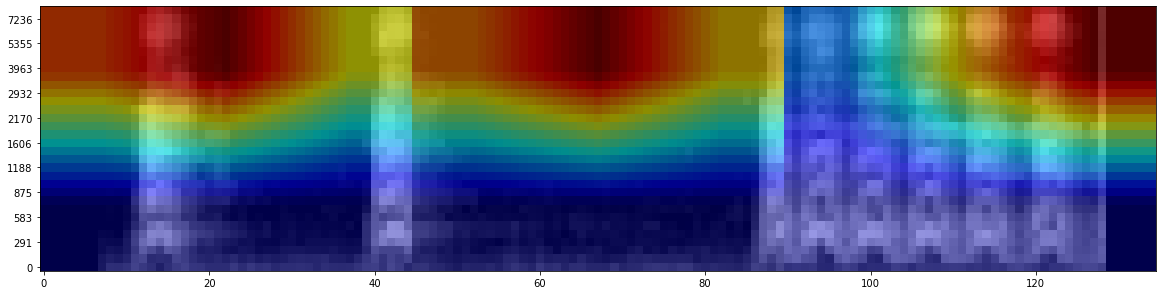

In [ ]:
signal, label, path = next(iterator)
print(path)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

### Multiple Heatmaps

In [ ]:
def gram_cam_heatmap(model, dataloader):
    negative = None
    positive = None
    for signal, label, _ in tqdm(dataloader, desc='Running the model inference'):
        res = None
        if torch.argmax(label).item():
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(1)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if positive is None:
                positive = res
            else:
                positive += res
        else:
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(0)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if negative is None:
                negative = res
            else:
                negative += res
    return positive, negative

In [ ]:
def plot_multiple_grad_cam(path, dataset_name, config):
    
    # sum_pos_heatmap = None
    # sum_neg_heatmap = None

    for f in config['datasets'][dataset_name]['folds']:            
        sum_pos_heatmap = None
        sum_neg_heatmap = None
        print(f)
        cam_model, _ = load_cam_model(path, config, fold=f, layers_from_end=-4)
        dataloader_esc = load_dataloader(path, config, fold=f)    
        pos_heatmap, neg_heatmap = gram_cam_heatmap(cam_model, dataloader_esc)
        if sum_pos_heatmap is None:
            sum_pos_heatmap = pos_heatmap
        else:
            sum_pos_heatmap += pos_heatmap

        if sum_neg_heatmap is None:
            sum_neg_heatmap = neg_heatmap
        else:
            sum_neg_heatmap += neg_heatmap

        if sum_pos_heatmap is not None:
            plot_heatmap(sum_pos_heatmap, pred=None, mel_to_freq=True, n_mels=config['transforms']['mel_spectrogram']['n_mels'], sr=config['target_sr'])
            # plt.title('Siren')
            plt.show()
        if sum_neg_heatmap is not None:
            plot_heatmap(sum_neg_heatmap, pred=None, mel_to_freq=True, n_mels=config['transforms']['mel_spectrogram']['n_mels'], sr=config['target_sr'])
            # plt.title('Not Siren')
            plt.show()
    

### Positive and negative

#### 16000 Hz 1.5s Mel 32

1


Running the model inference: 100%|██████████| 400/400 [00:50<00:00,  7.87it/s]


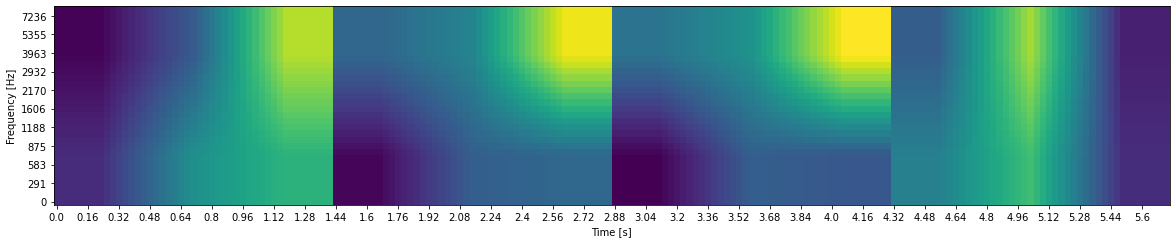

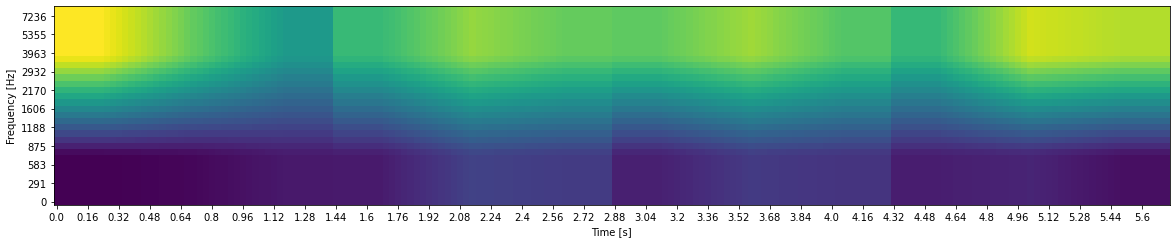

2


Running the model inference: 100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


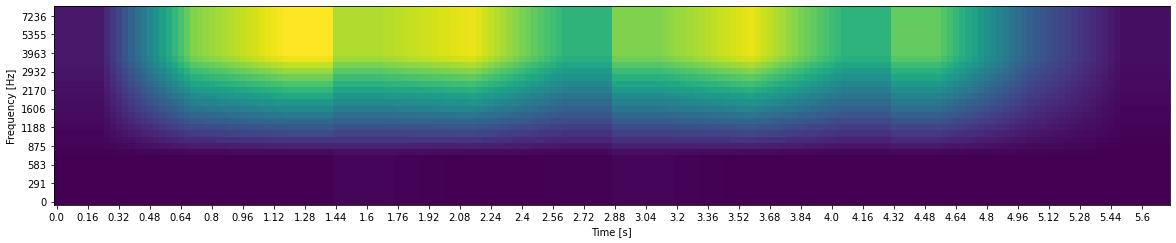

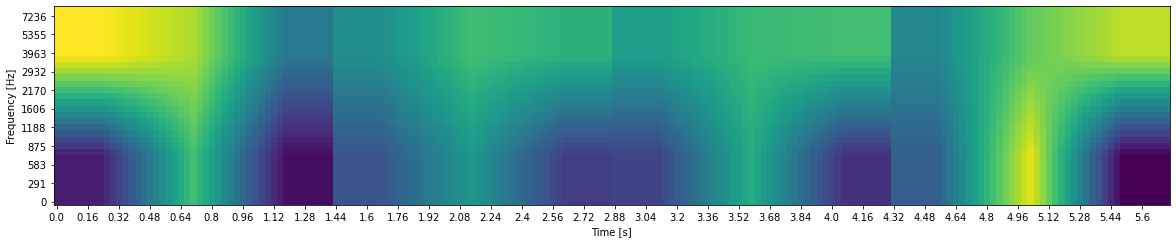

3


Running the model inference: 100%|██████████| 400/400 [00:50<00:00,  7.88it/s]


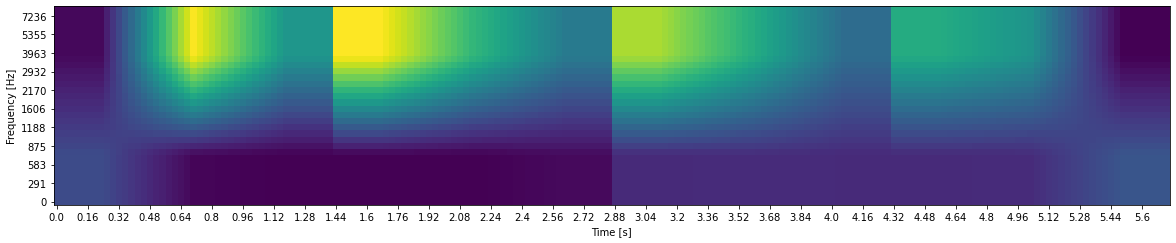

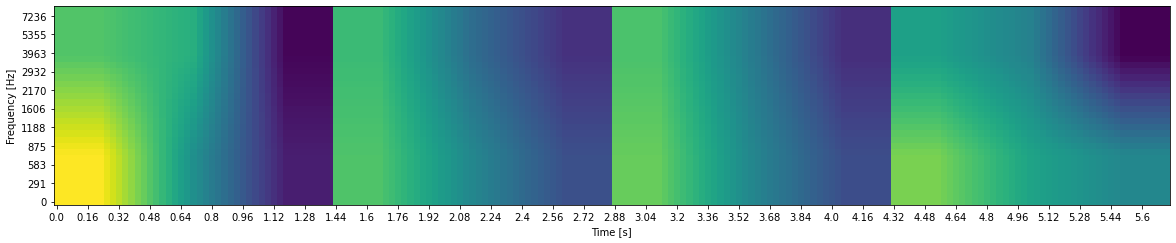

4


Running the model inference: 100%|██████████| 400/400 [00:55<00:00,  7.20it/s]


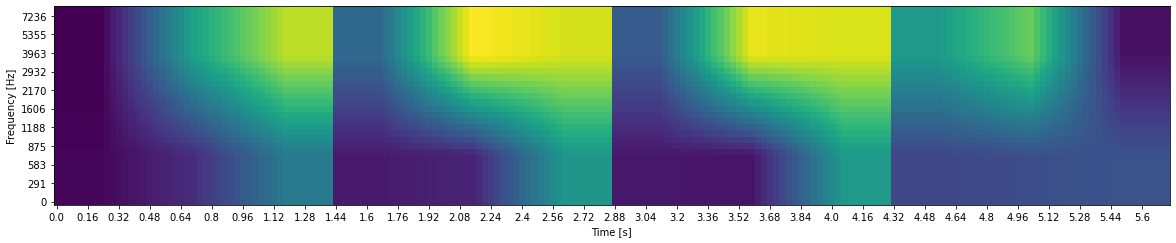

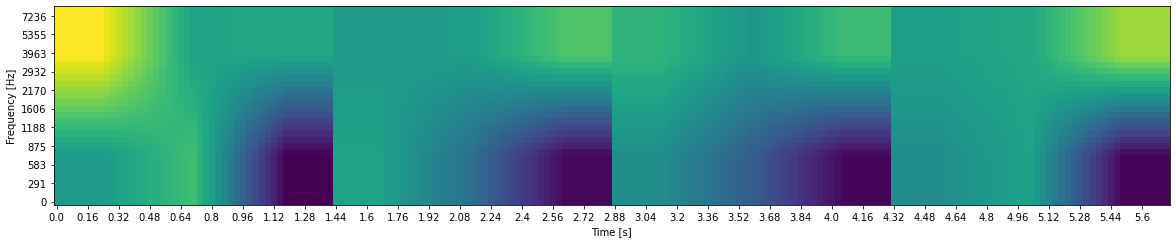

5


Running the model inference: 100%|██████████| 400/400 [00:56<00:00,  7.08it/s]


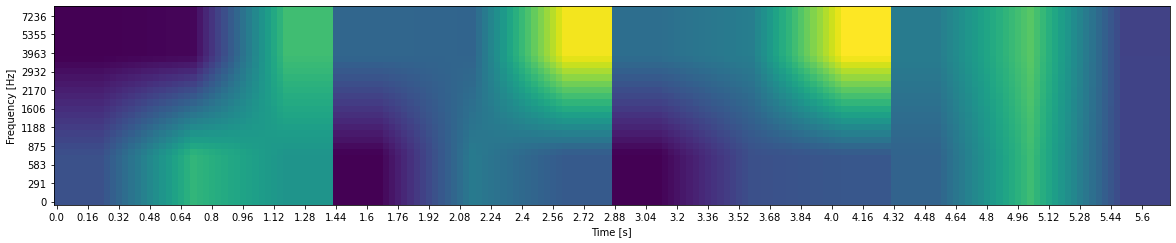

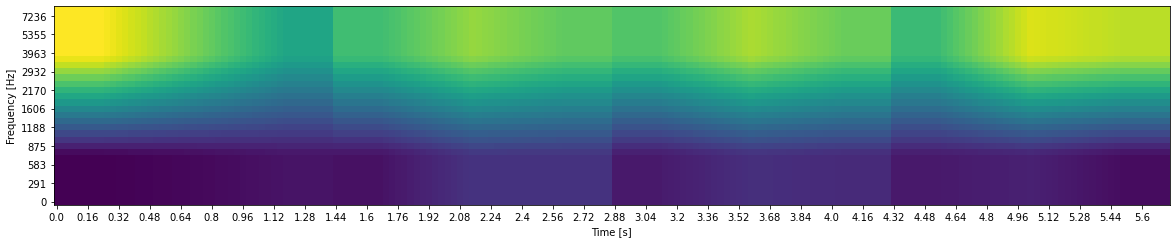

In [ ]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

Running the model inference: 100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


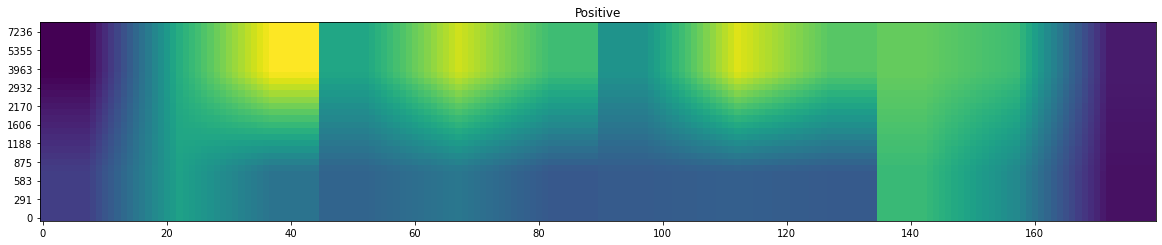

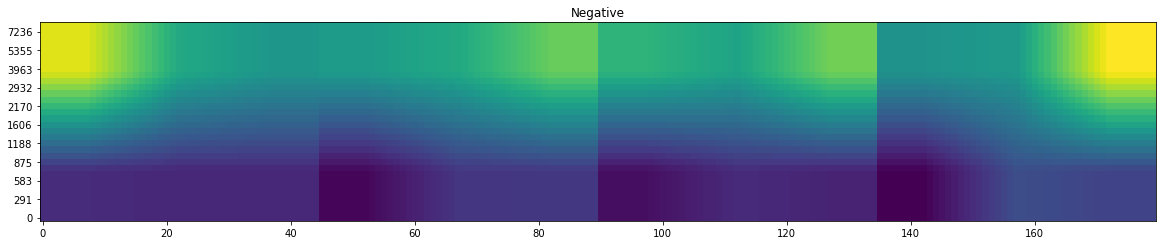

In [ ]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 16000 Hz 1.5s Mel 64

Running the model inference: 100%|██████████| 400/400 [00:47<00:00,  8.39it/s]


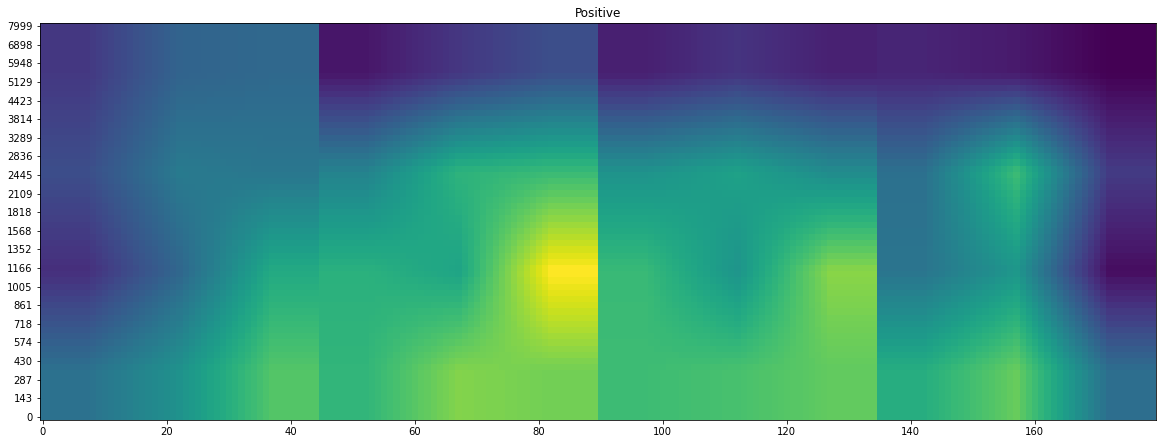

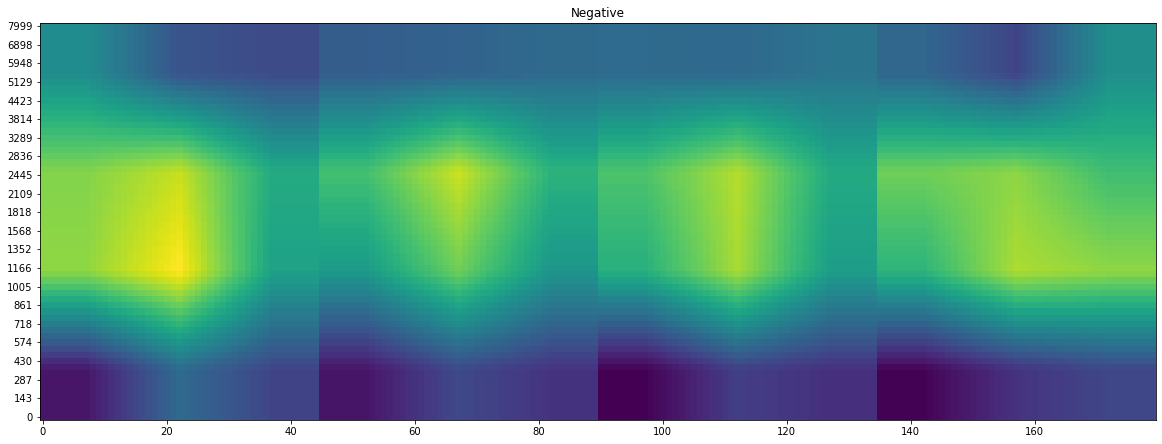

In [ ]:
path = "./trained_models/esc50/16000-15-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

Running the model inference: 100%|██████████| 400/400 [00:47<00:00,  8.41it/s]


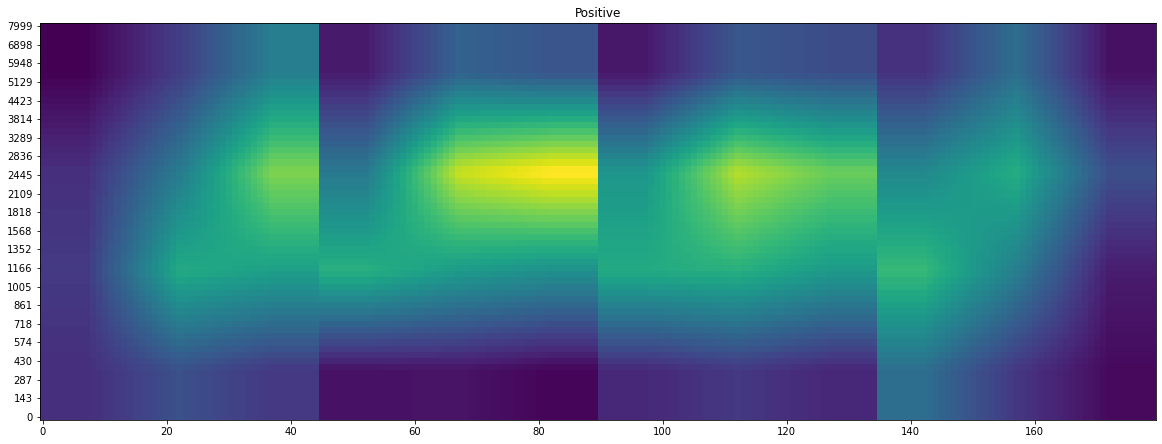

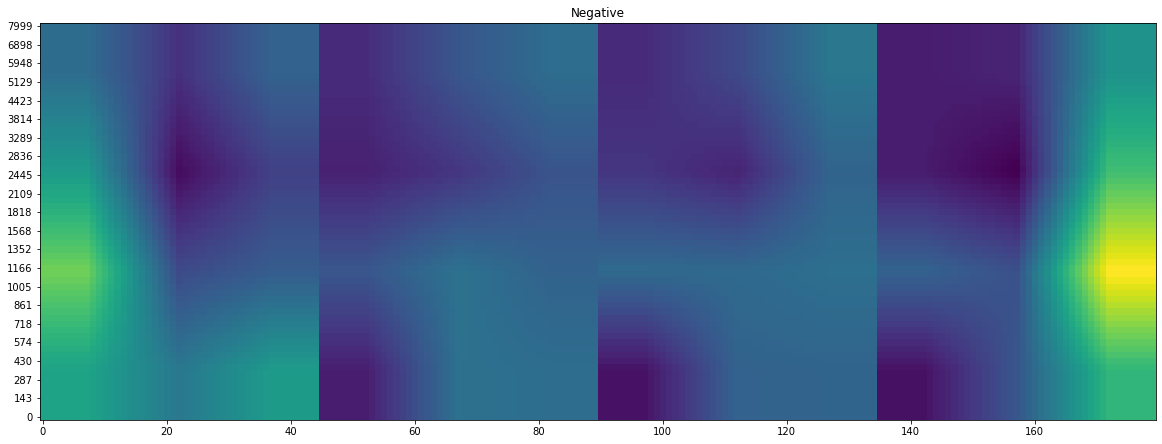

In [ ]:
path = "./trained_models/esc50/16000-15-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 8820 Hz 1s MFCC 32

5


Running the model inference: 100%|██████████| 400/400 [00:59<00:00,  6.69it/s]


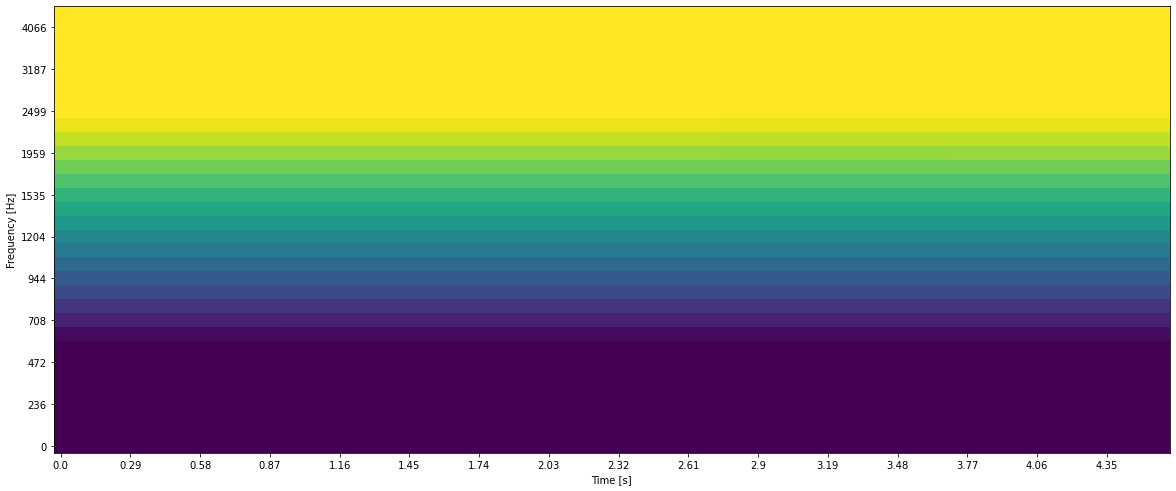

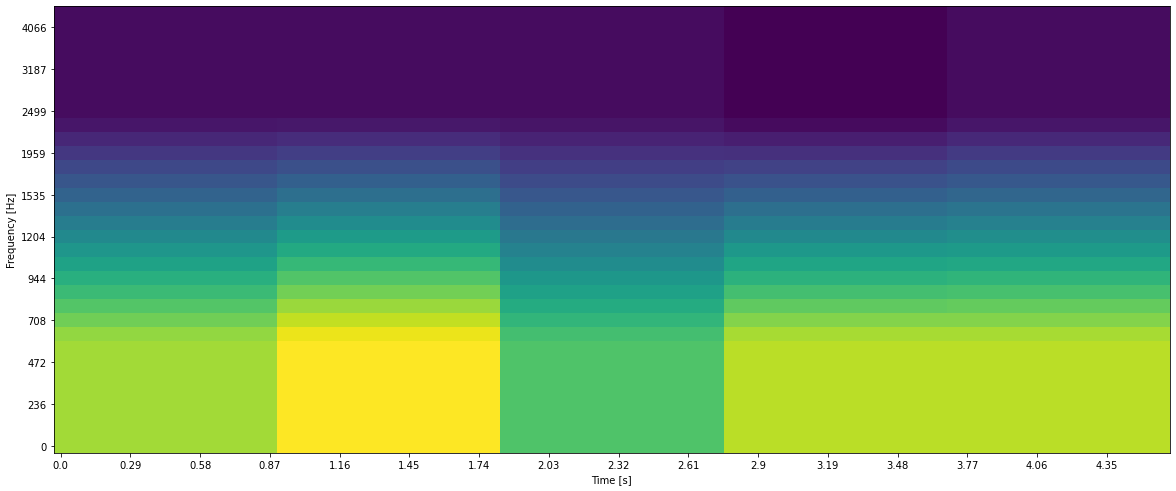

4


Running the model inference: 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]


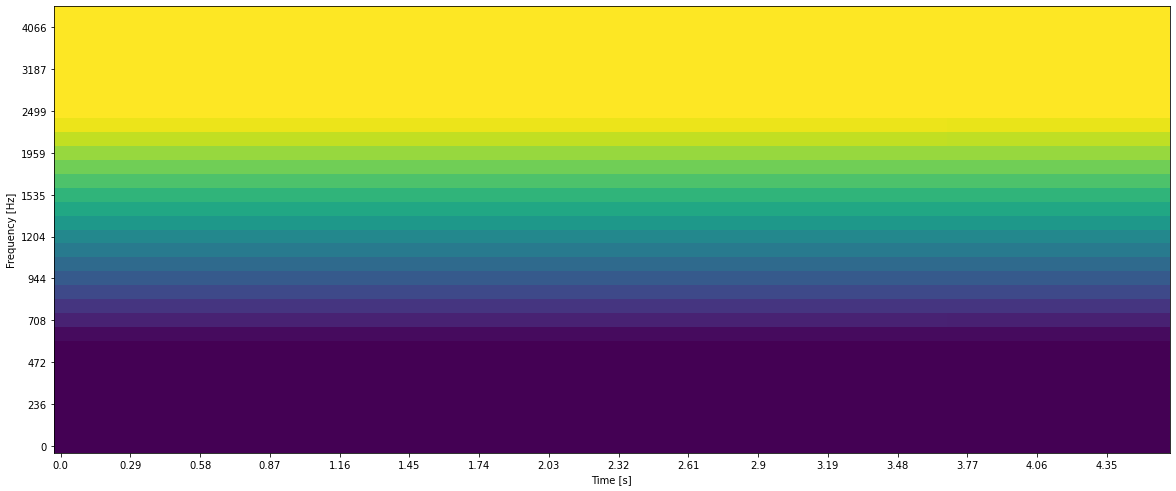

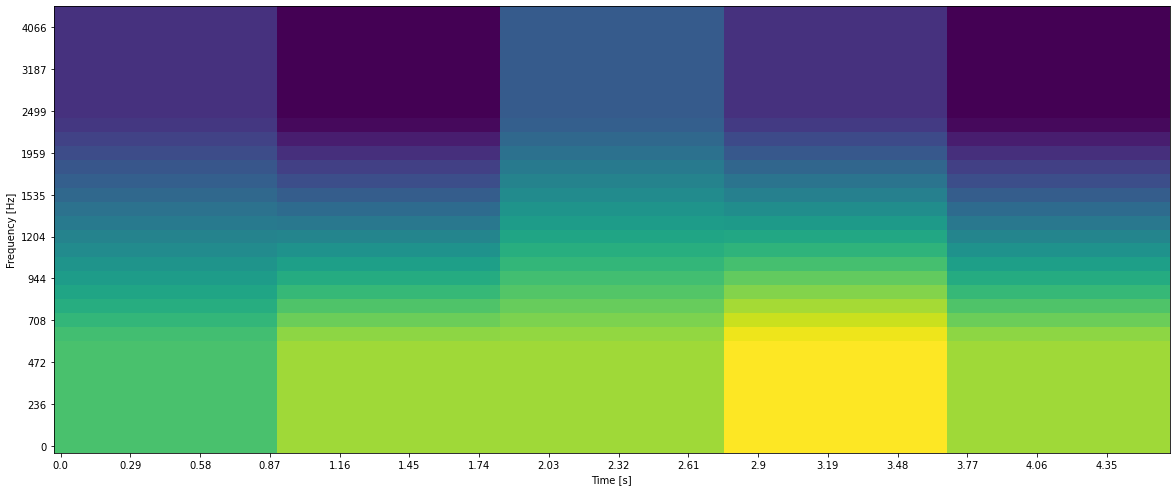

3


Running the model inference: 100%|██████████| 400/400 [00:58<00:00,  6.85it/s]


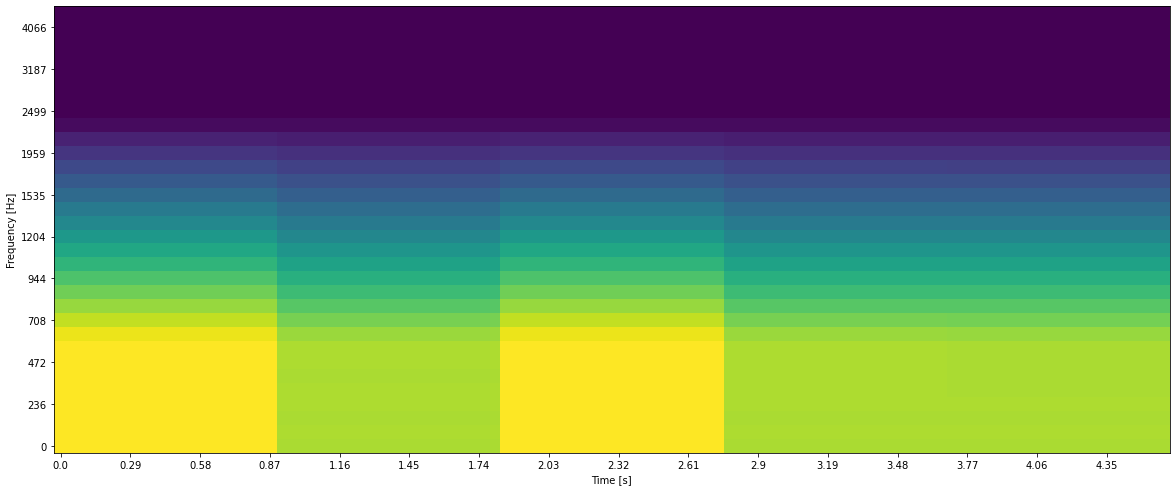

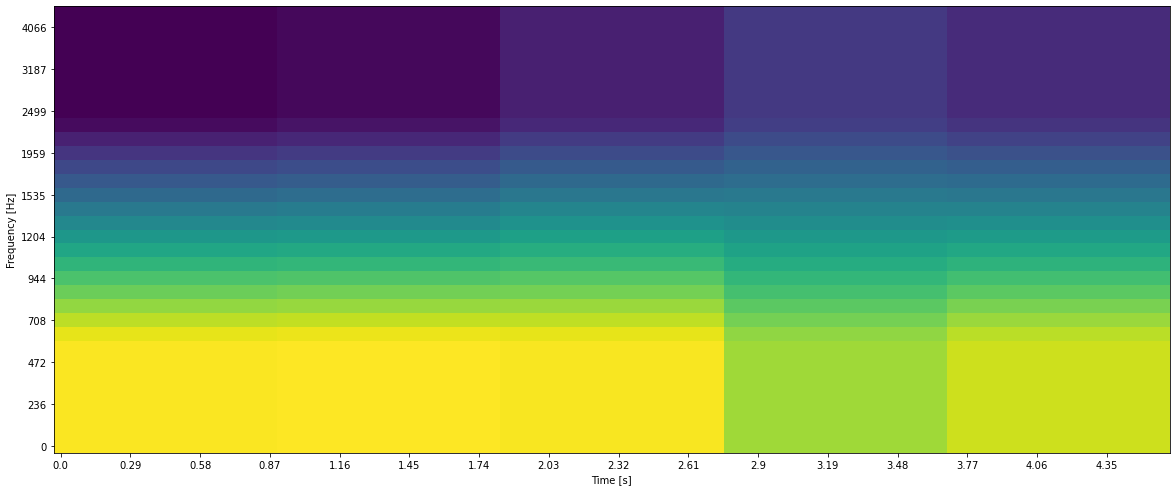

2


Running the model inference: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s]


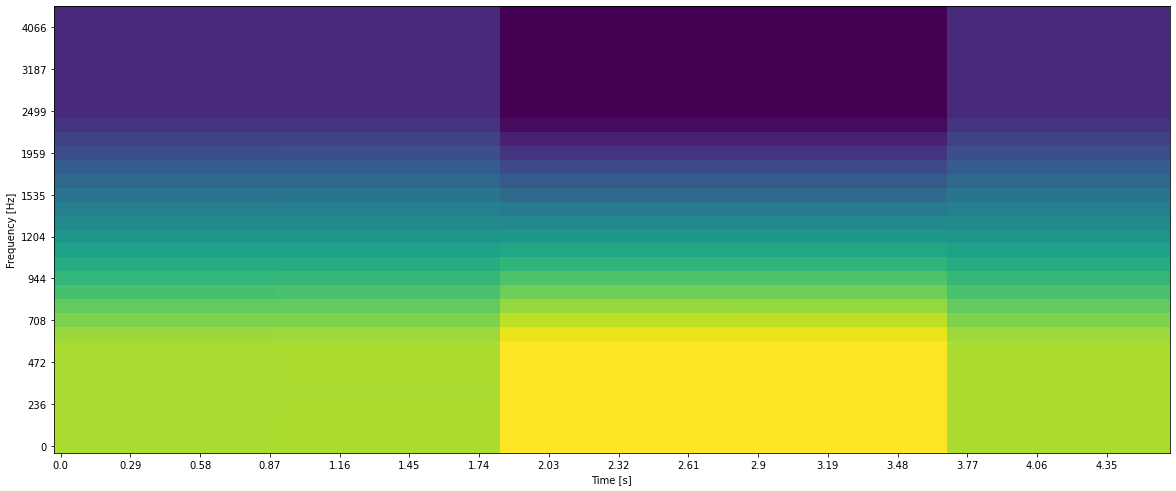

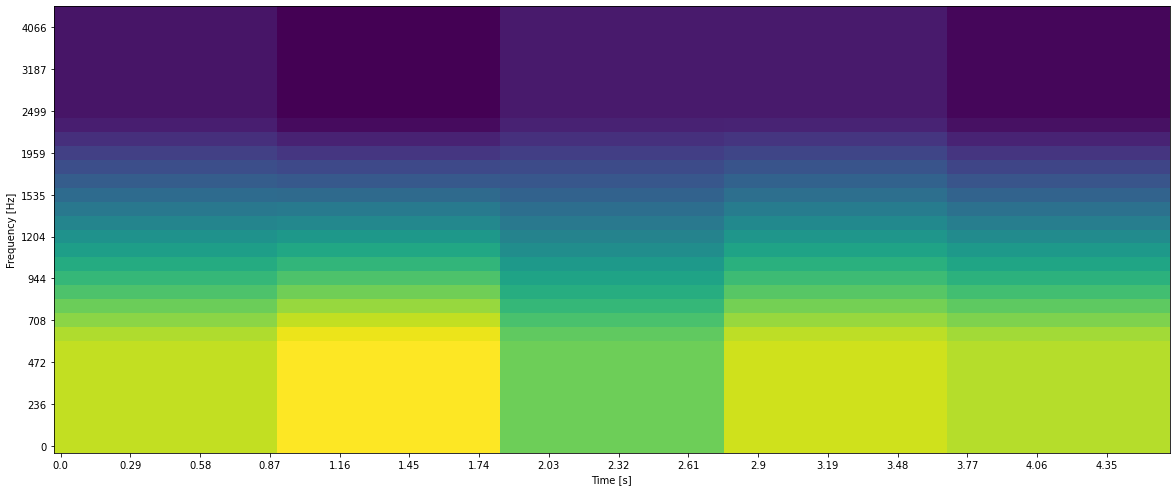

1


Running the model inference: 100%|██████████| 400/400 [00:58<00:00,  6.80it/s]


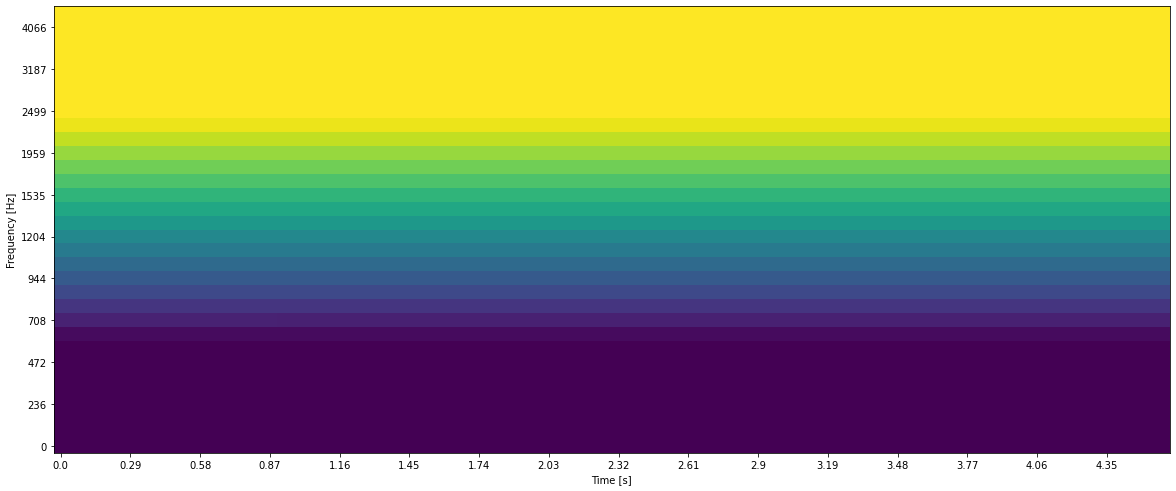

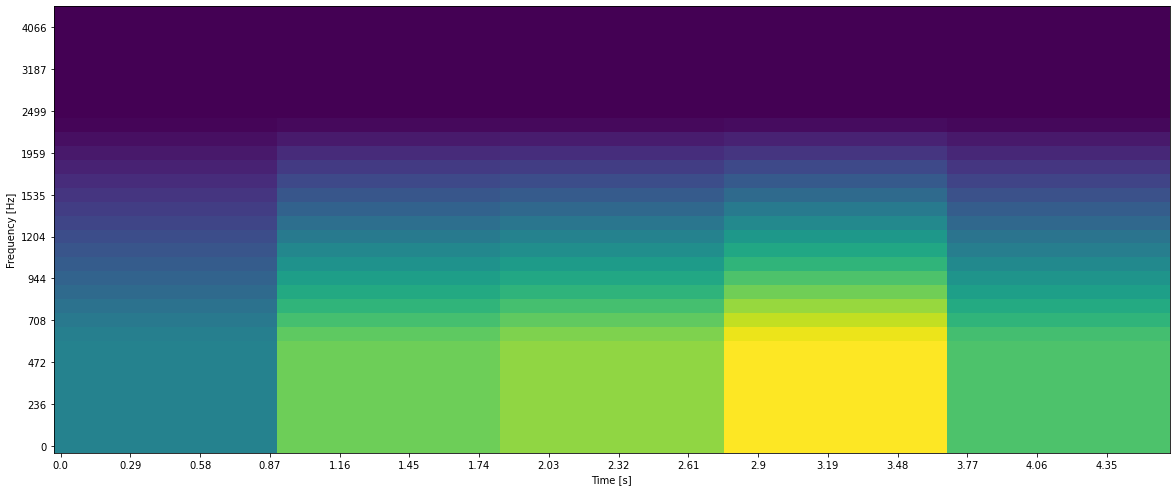

In [ ]:
path = "./trained_models/esc50/8820-1-mfcc32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

Running the model inference: 100%|██████████| 400/400 [00:54<00:00,  7.40it/s]


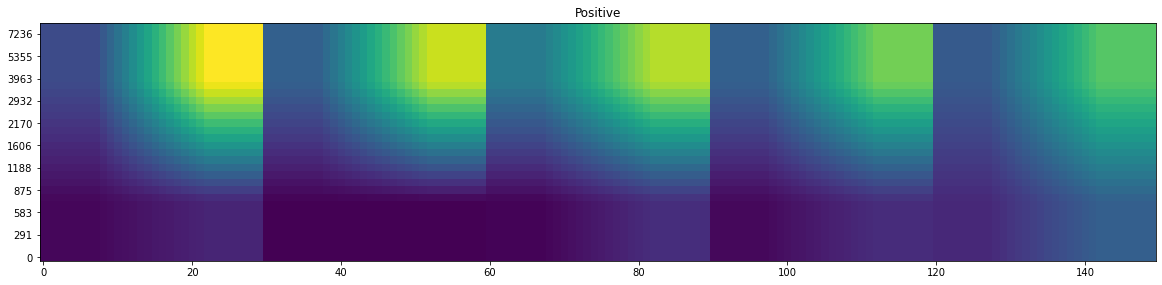

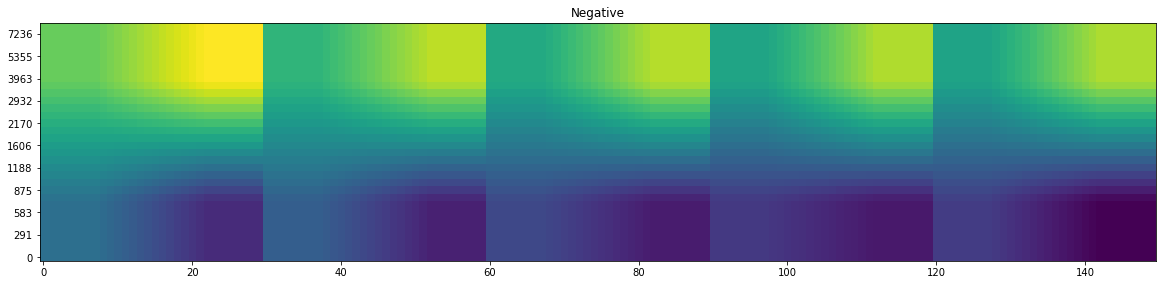

In [ ]:
path = "./trained_models/esc50/16000-1-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 16000 Hz 1s Mel 64

Running the model inference: 100%|██████████| 400/400 [00:58<00:00,  6.87it/s]


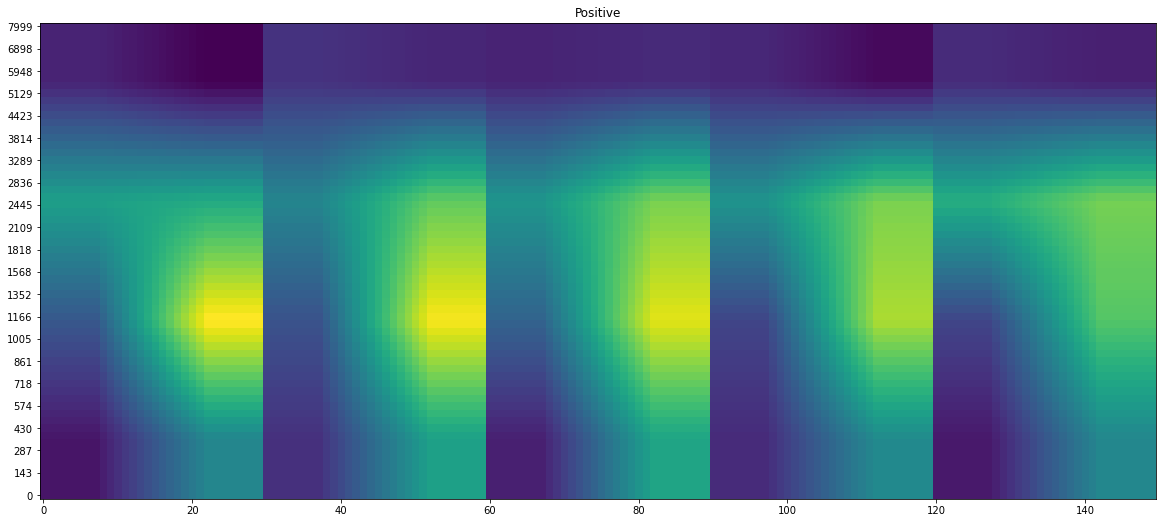

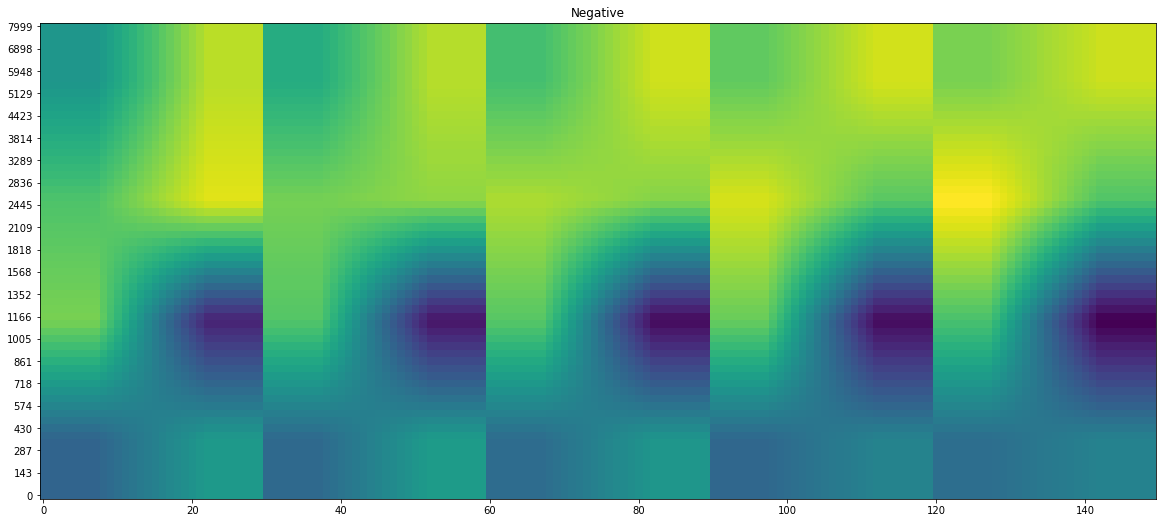

In [ ]:
path = "./trained_models/esc50/16000-1-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

Running the model inference: 100%|██████████| 400/400 [00:55<00:00,  7.25it/s]


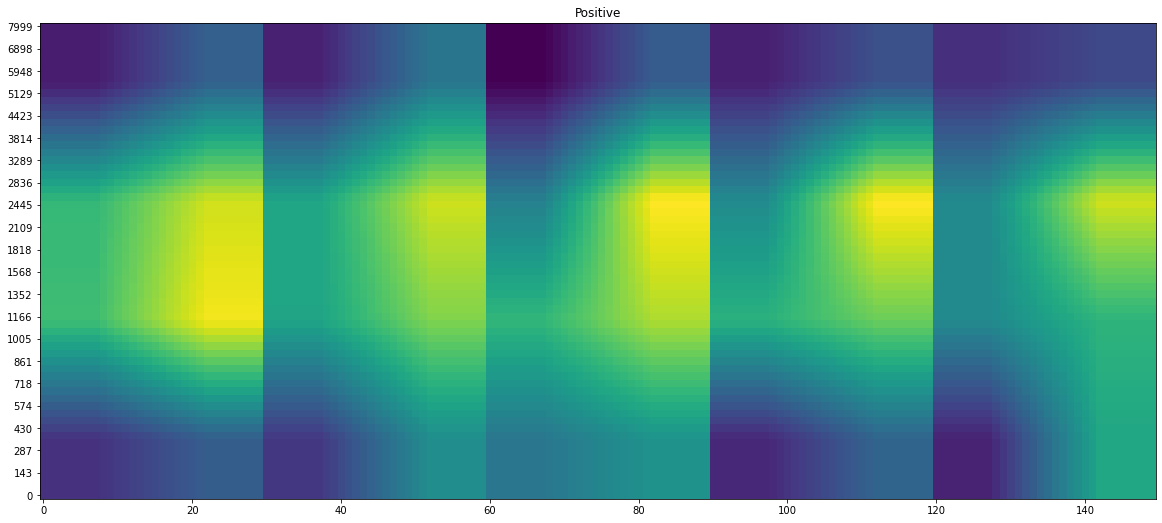

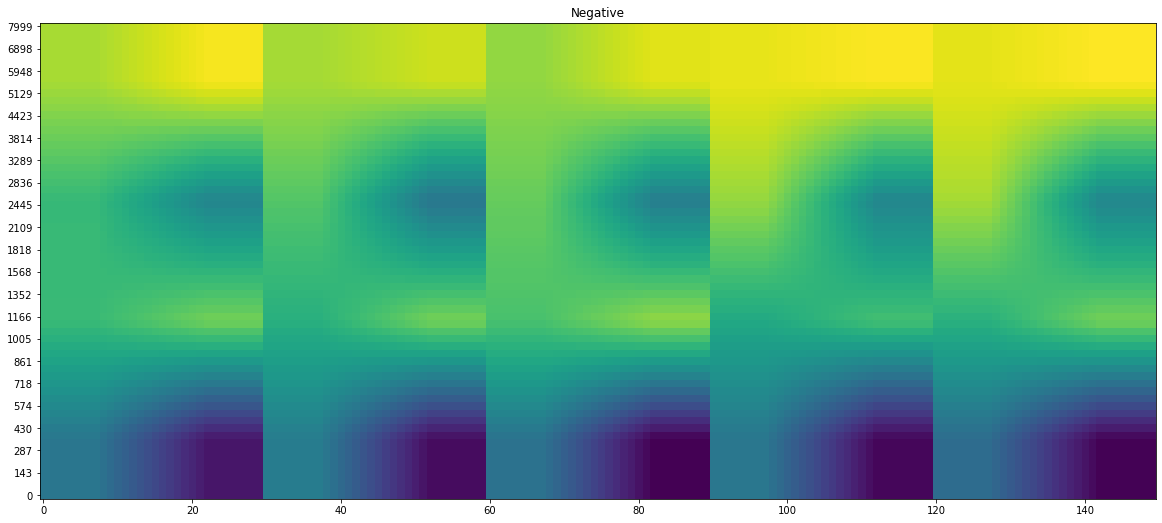

In [ ]:
path = "./trained_models/esc50/16000-1-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### 16000 Hz 1.5s Mel 32

#### Siren

1


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


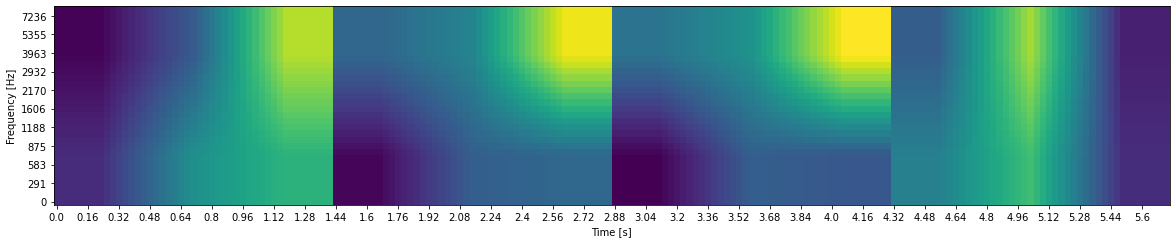

2


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


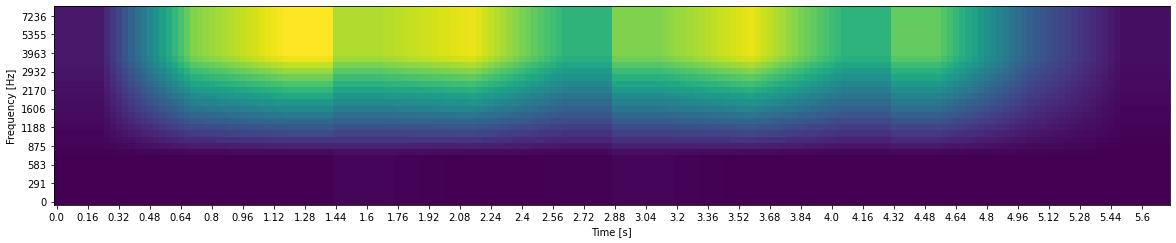

3


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


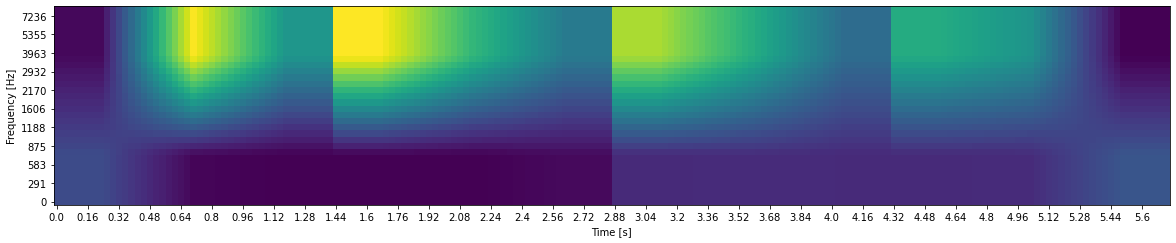

4


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


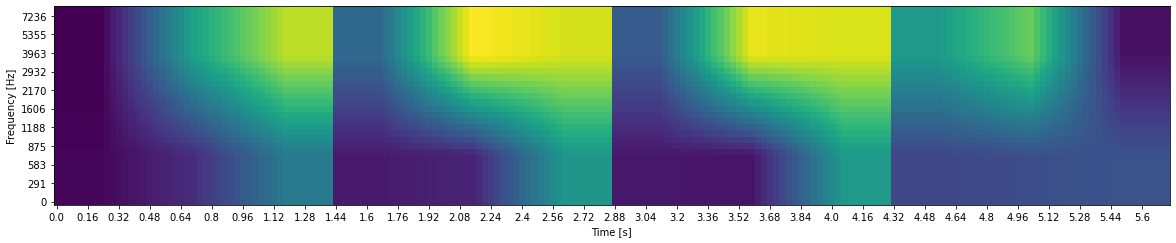

5


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


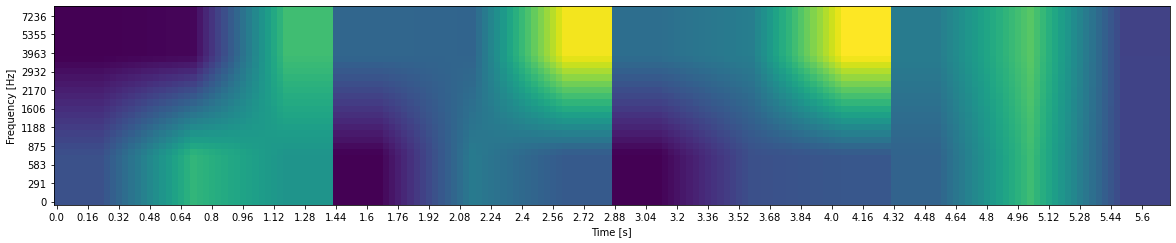

In [ ]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

 ### Car Horn

5


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


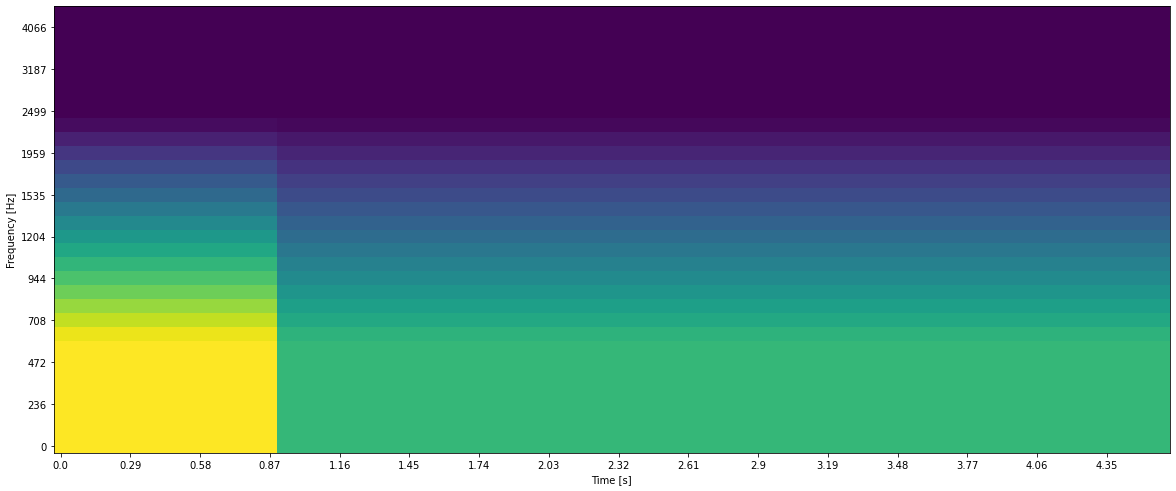

4


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


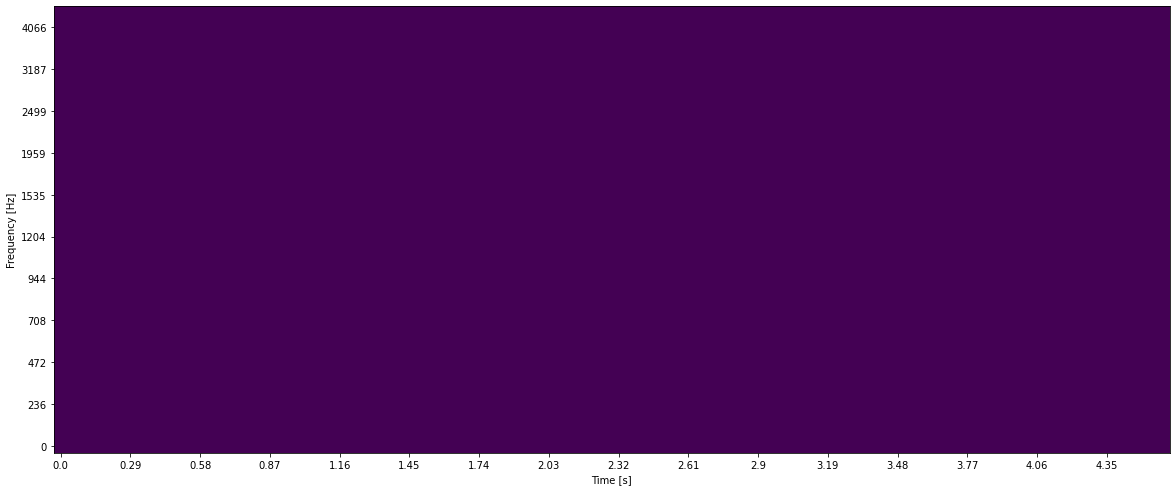

3


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]


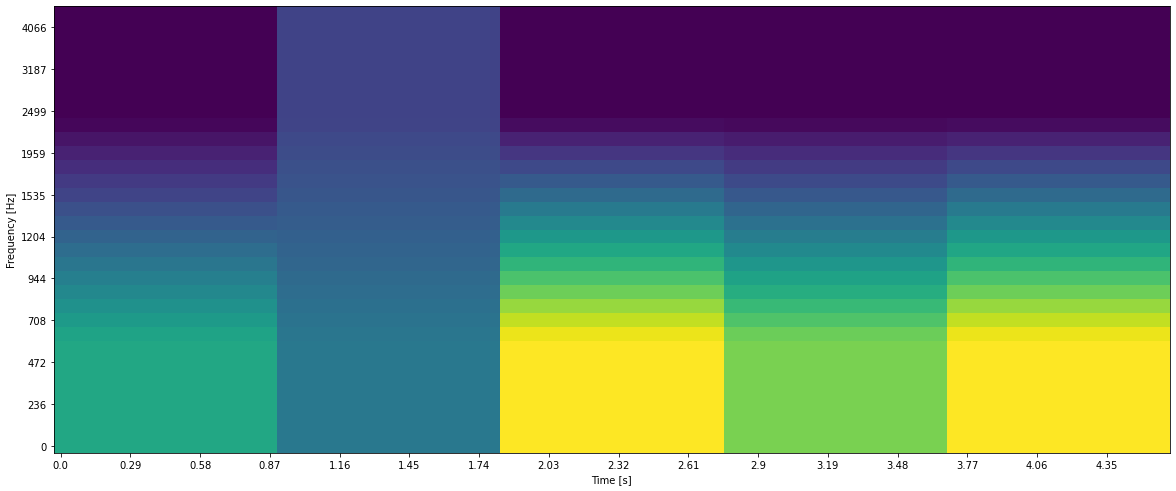

2


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


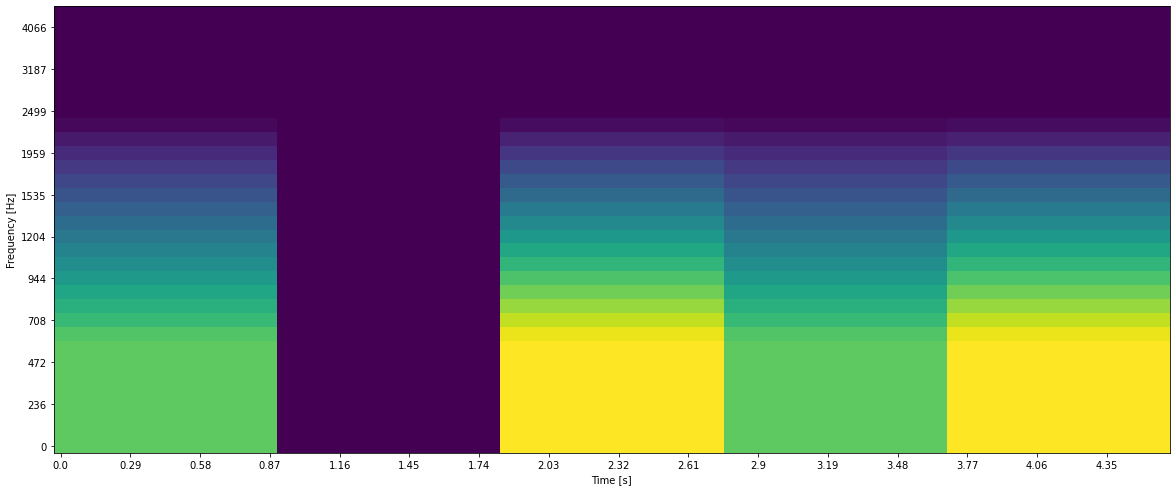

1


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


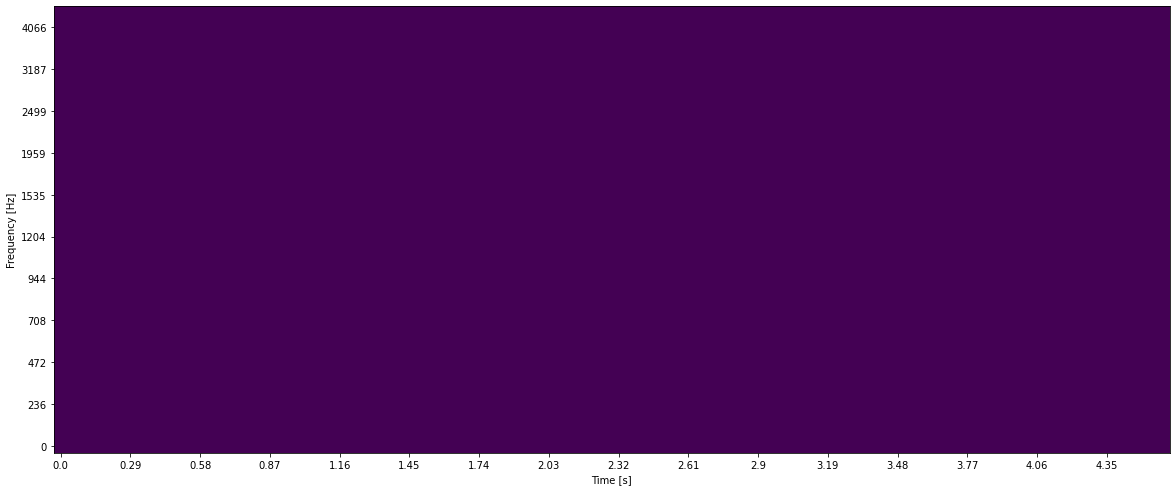

In [ ]:
path = "./trained_models/esc50/8820-1-mfcc32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### Engine

5


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


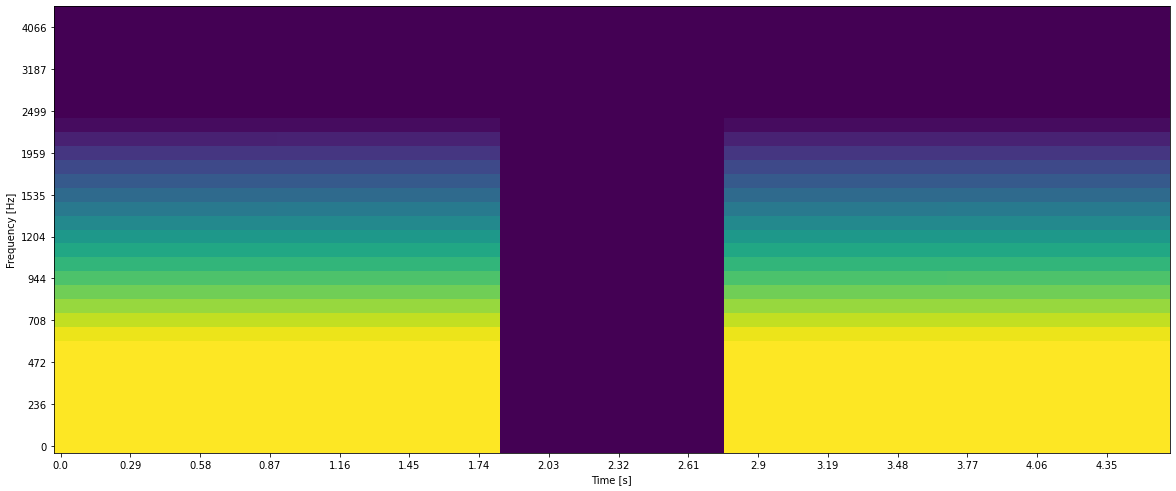

4


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


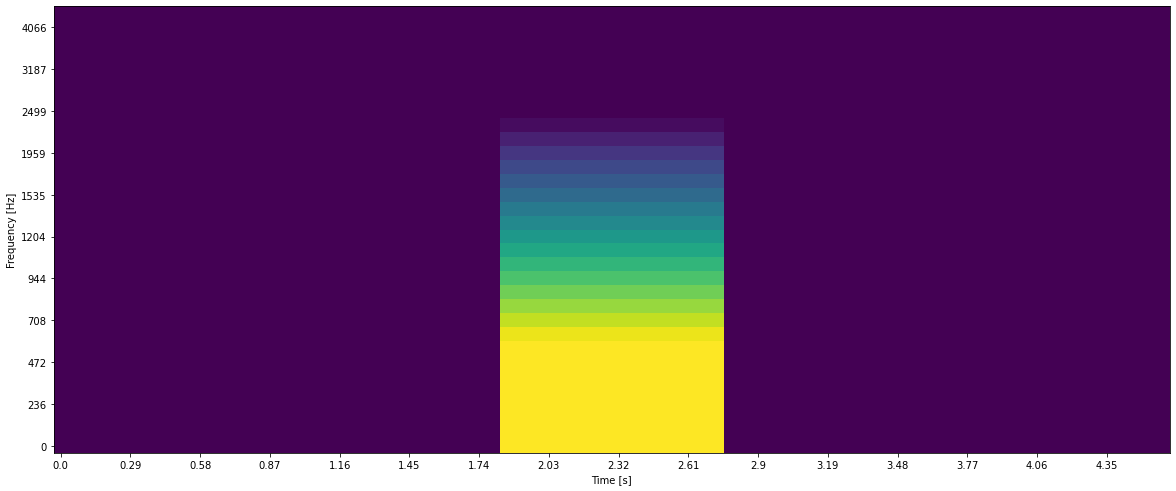

3


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


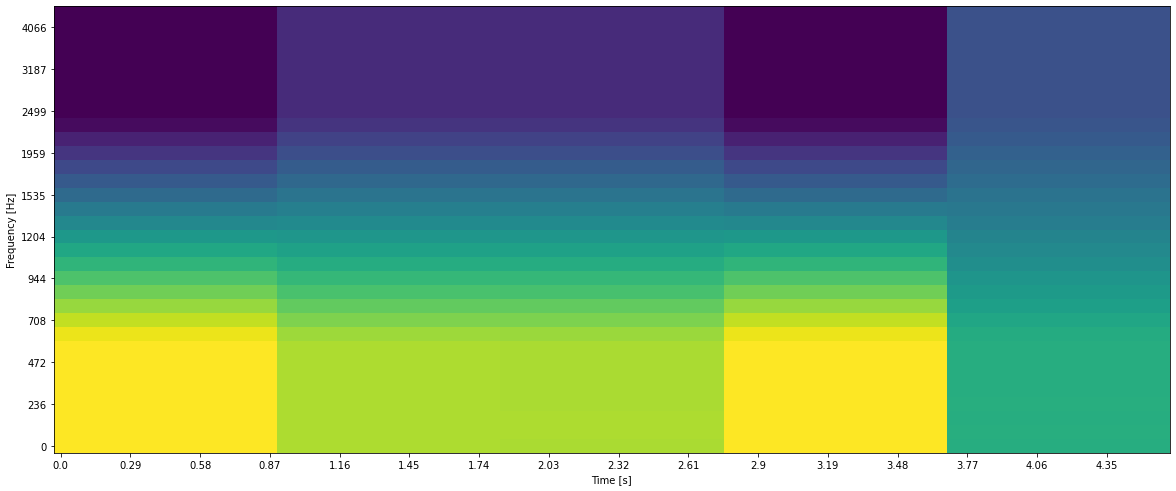

2


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]


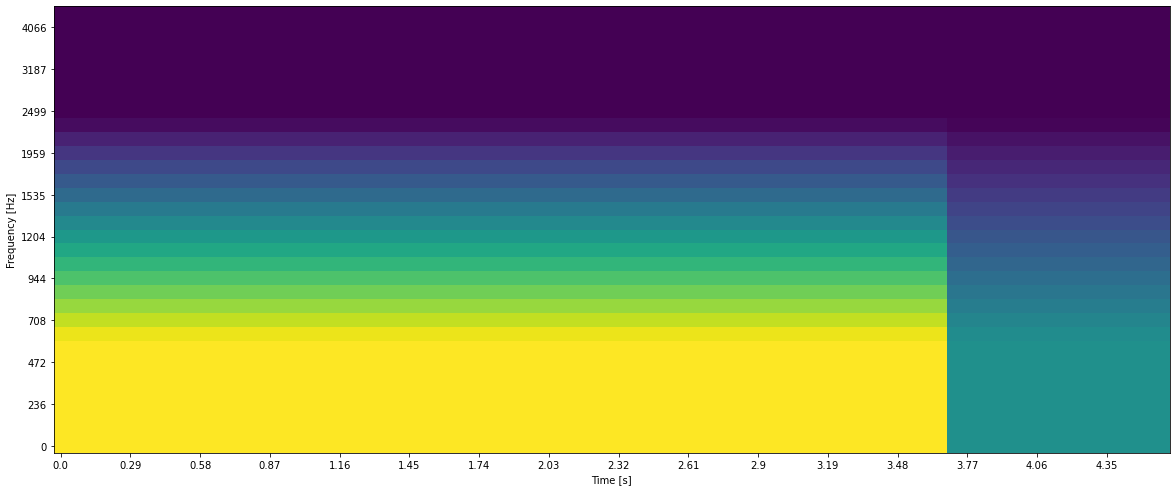

1


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


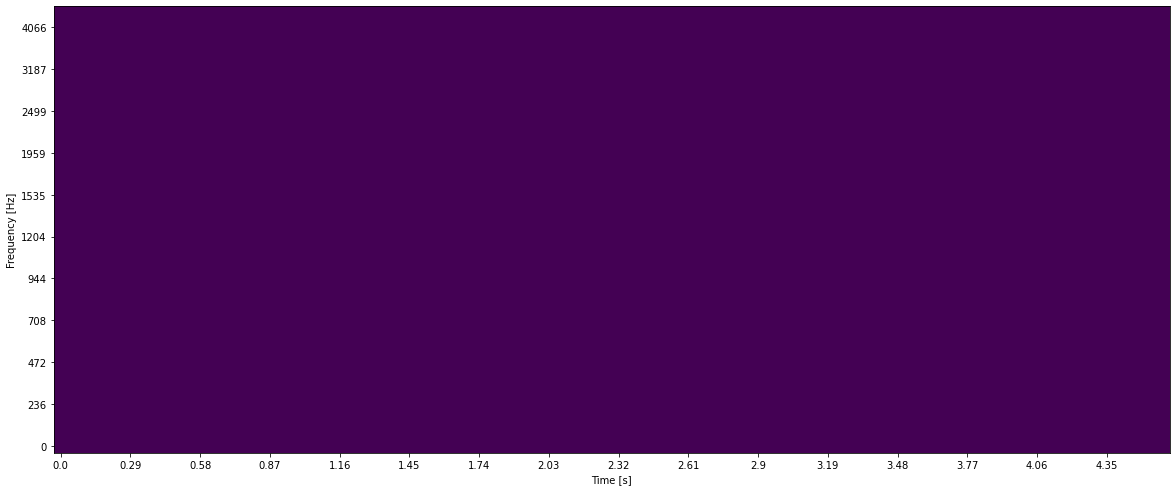

In [ ]:
path = "./trained_models/esc50/8820-1-mfcc32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### Wind

5


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]


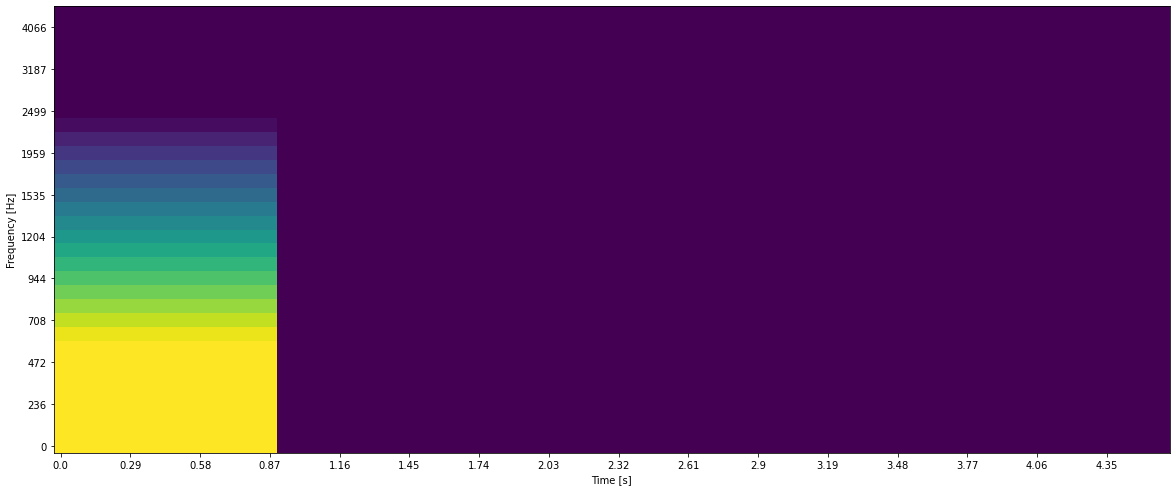

4


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


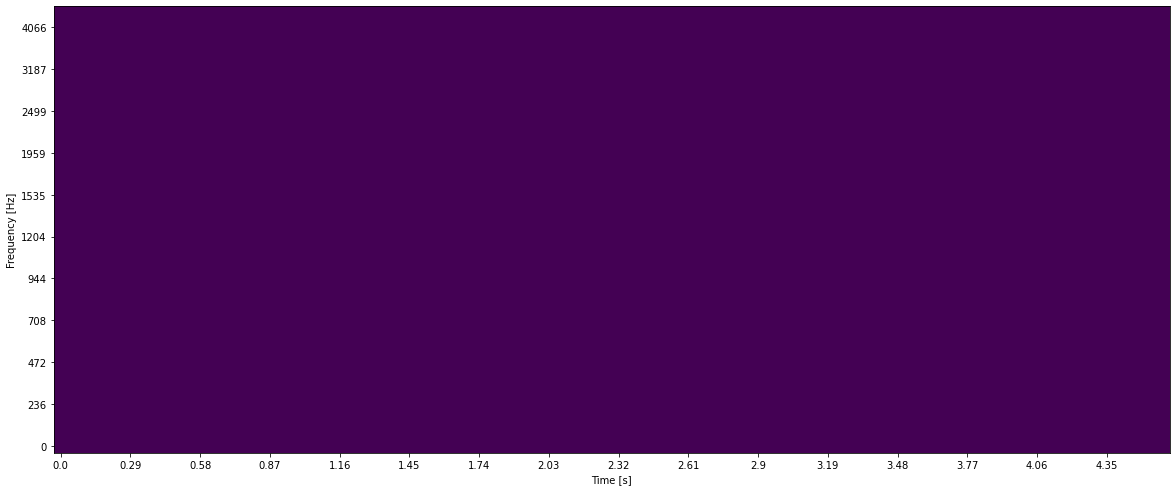

3


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


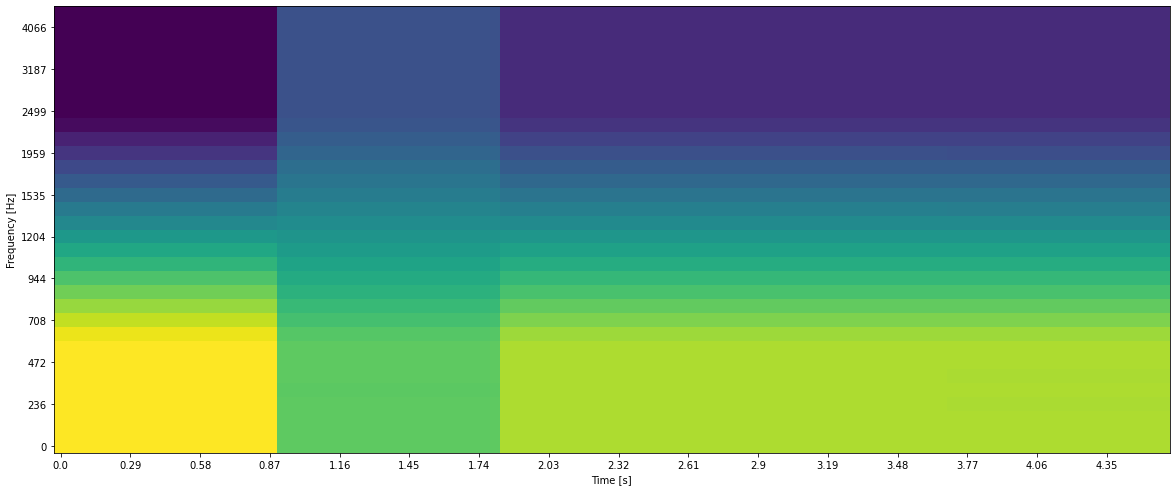

2


Running the model inference: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


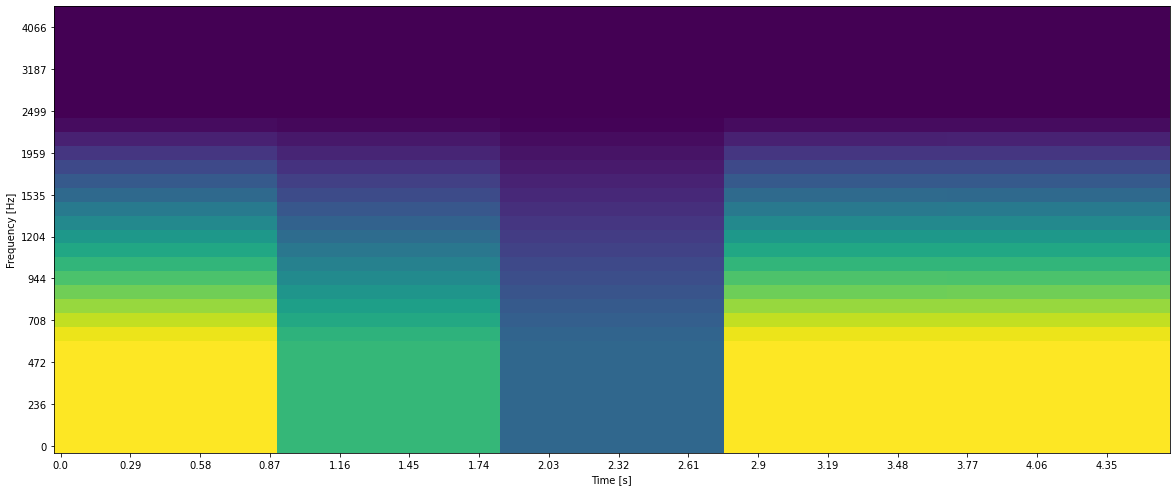

1


Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


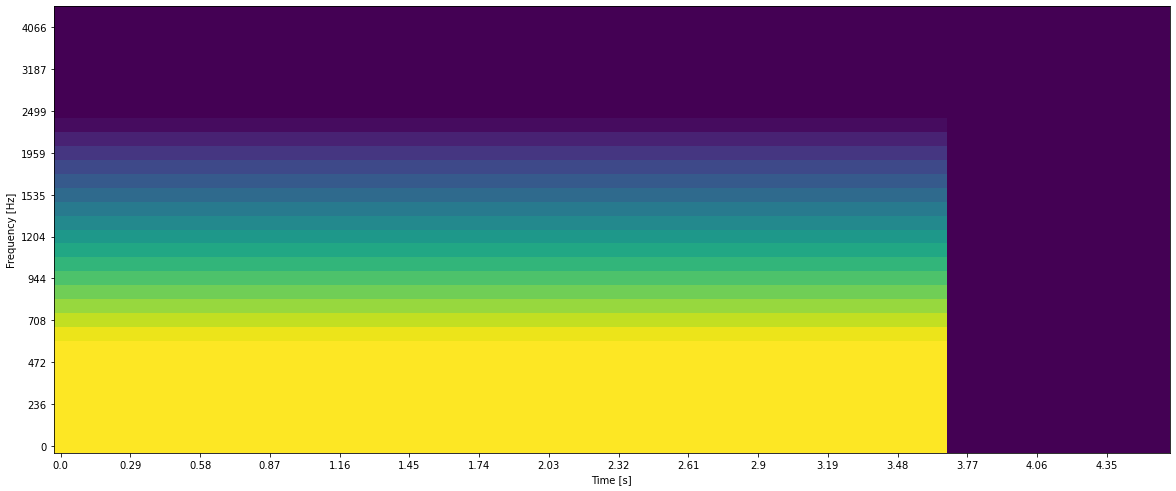

In [ ]:
path = "./trained_models/esc50/8820-1-mfcc32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)